In [1]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import linregress
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

from scipy.stats import ttest_ind
from scipy.stats import levene

import os
import os.path
from os import path

import glob

import math

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
def mean_data(df):
    items = list(set([c[:-1] for c in df.columns.to_list()]))

    
    numbers = list(range(0,len(items)))
    data = []
    mean = pd.DataFrame(data)
    for i in numbers:
        cols = [c for c in df if c.startswith(items[i])]

        mean[items[i]] = df.loc[:,cols].mean(1)
    return mean

In [3]:
def statistic_f(DATASET1, DATASET2):
    #testing normal distribution
    if len(DATASET1) > 5000 or len(DATASET2) > 5000:
        p_normaldist1 = stats.kstest(DATASET1, stats.norm.cdf)[1]
        p_normaldist2 = stats.kstest(DATASET2, stats.norm.cdf)[1]
    if len(DATASET1) < 3 or len(DATASET2) < 3:
        p_normaldist1 = 1
        p_normaldist2 = 1
    else:
        p_normaldist1 = stats.shapiro(DATASET1)[1]
        p_normaldist2 = stats.shapiro(DATASET2)[1]
    
    #testing variance
    stat, p_levene = levene(DATASET1, DATASET2)
    
    if p_normaldist1 < 0.05 or p_normaldist2 < 0.05:
        p_ttest = stats.mannwhitneyu(DATASET1, DATASET2)[1]  #Mann whitney U test
        print('The data is not normaly distributed, so the  Mann-Whitney U test was performed')
    else:
        if p_levene < 0.05:
            equal_True_False = False
            print('The data is normaly distributed but has no equal variance so Welch´s T-test was perfomred')
        else:
            equal_True_False = True
            print('The data is normaly distributed and has equal variance so Student´s T-test was perfomred')
        p_ttest = stats.ttest_ind(DATASET1, DATASET2 ,equal_var=equal_True_False)[1] # t-test
    return(p_ttest)

def cohens_d(DATASET1, DATASET2):
    #calculating Cohen´s d
    mean_difference = np.mean(DATASET1) - np.mean(DATASET2)
    pooled_standard_deviation = np.sqrt((np.var(DATASET1) + np.var(DATASET2)) / 2)
    cohen_d = mean_difference / pooled_standard_deviation
    return(cohen_d)

def statistic_asterisk(p_value):
    #statistics depiction with asterisks
    if p_value < 0.0001:
        p_value_plot = '****'
    elif p_value < 0.001:
        p_value_plot = '***'
    elif p_value < 0.01:
        p_value_plot = '**'
    elif p_value < 0.05:
        p_value_plot = '*'
    else:
        p_value_plot = 'ns'
    return(p_value_plot)
    

In [4]:
PATH = 'C:/Users/felix/Documents/Phd'

# Tissue splice analysis

In [6]:
GO_secretion = pd.read_excel(PATH + '/RNAseq_Felix/GOterm_Lists/GOsecretion_human2.xlsx')
GO_secretion = GO_secretion.set_index('geneSymbol')

In [8]:
#read RMATS files and create dictionary with PSI of all splicing events of all conditions(tissues)
splicing_dict = {} #create empty dictionary
splicing_secretion_dict = {} #create specialized dictionary (GO term secretion) 
#list of conditions(tissues)
list_condition = ['liver', 'bonemarrow', 'brain',  'colon', 'esophagus', 'fat', 'heart', 'kidney'
            ,'lung', 'lymphnode', 'placenta', 'skin'
            , 'smallintestine', 'spleen', 'stomach', 'testis', 'thyroid'
            ,'urinarybladder']
source_path = PATH +  '/RNAseq_Felix/human_tissues/Bioinfo/RMATS_filter/'

def read_splice_events(TYPE, tissue, path):
    if tissue == 'liver':
        splicing = pd.read_excel(f'{path}Livervsbrain/{TYPE}_Livervsbrain.xlsx'
                                ,usecols = [2,3,4,5,6,7,8,9,10,13,14,17,18,19])
        #combine coordinates in one "coord" column
        splicing['coord_chr'] = splicing.iloc[:, 1]
        splicing['coord_1'] = splicing.iloc[:, 3]
        splicing['coord_2'] = splicing.iloc[:, 4]
        splicing['coord_3'] = splicing.iloc[:, 5]
        splicing['coord_4'] = splicing.iloc[:, 6]
        splicing['coord_5'] = splicing.iloc[:, 7]
        splicing['coord_6'] = splicing.iloc[:, 8]
        
        coverage_list = []
        for i in range(len(splicing)):
            coverage_list.append(np.mean(list(map(int, splicing['IJC_SAMPLE_1'][i].split(",")))) + np.mean(list(map(int, splicing['SJC_SAMPLE_1'][i].split(",")))))
        splicing['mean_coverage'] = coverage_list
        splicing = splicing.query('mean_coverage > 10')
        
        #drop the unused columns
        splicing = splicing.drop(splicing.columns[[1,3,4,5,6,7,8,9,10,21]],axis = 1)
        #include a splice type column
        splicing['Type'] = TYPE 
        return splicing
    
    else:
        
        splicing = pd.read_excel(f'{path}Livervs{tissue}/{TYPE}_Livervs{tissue}.xlsx')
        #combine coordinates in one "coord" column
        splicing['coord_chr'] = splicing.iloc[:, 3]
        splicing['coord_1'] = splicing.iloc[:, 5]
        splicing['coord_2'] = splicing.iloc[:, 6]
        splicing['coord_3'] = splicing.iloc[:, 7]
        splicing['coord_4'] = splicing.iloc[:, 8]
        splicing['coord_5'] = splicing.iloc[:, 9]
        splicing['coord_6'] = splicing.iloc[:, 10]
        
        coverage_list = []
        for i in range(len(splicing)):
            coverage_list.append(np.mean(list(map(int, splicing['IJC_SAMPLE_1'][i].split(",")))) + np.mean(list(map(int, splicing['SJC_SAMPLE_1'][i].split(",")))))
        splicing['mean_coverage'] = coverage_list
        splicing = splicing.query('mean_coverage > 10')
        
        #drop the unused columns
        splicing = splicing.drop(splicing.columns[[0,1, 3, 5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]],axis = 1)
        splicing = splicing.drop('mean_coverage',axis = 1)
        #include a splice type column
        splicing['Type'] = TYPE 
        return splicing


#loop over condition in 
for x in list_condition:
    #read files
    SE = read_splice_events('SE', x, source_path)
    RI = read_splice_events('RI', x, source_path)
    A3SS = read_splice_events('A3SS', x, source_path)
    A5SS = read_splice_events('A5SS', x, source_path)
    
    #add to the dictionary a DataFrame with all splice events in the key of the condition 
    splicing_dict[f'{x}'] = pd.DataFrame(pd.concat([SE, RI,  A5SS, A3SS], axis = 0))
    #add to the specialized dicitonary with the merge with the secretion GO term
    splicing_secretion_dict[f'{x}'] = splicing_dict[f'{x}'].reset_index().merge(GO_secretion
                                        , on = 'geneSymbol')

In [9]:
for i in splicing_dict:
    splicing_dict[i] = splicing_dict[i].set_index(['geneSymbol', 'strand', 'coord_chr', 'coord_1', 'coord_2', 'coord_3'
                                                            , 'coord_4', 'coord_5', 'coord_6', 'Type'])
    
for i in splicing_secretion_dict:
    splicing_secretion_dict[i] = splicing_secretion_dict[i].drop(['index', 'GO_term'], axis = 1)
    splicing_secretion_dict[i] = splicing_secretion_dict[i].set_index(['geneSymbol', 'strand', 'coord_chr', 'coord_1' 
                                                            ,'coord_2', 'coord_3'
                                                            , 'coord_4', 'coord_5', 'coord_6', 'Type'])
    

In [10]:
splicing = splicing_dict['liver']
for i in splicing_dict:
    if i == 'liver':
        pass
    else: 
        splicing = splicing.merge(splicing_dict[i], left_index=True, right_index=True, how = 'inner')

In [11]:
splicing_secretion = splicing_secretion_dict['liver']
for i in splicing_secretion_dict:
    if i == 'liver':
        pass
    else: 
        splicing_secretion = splicing_secretion.merge(splicing_secretion_dict[i], 
                                                      left_index=True, right_index=True, how = 'inner')
     

In [56]:
splicing.reset_index().sort_values(by=['geneSymbol']).reset_index().drop('index' 
                                , axis = 1).to_excel('G:/Projects/SEC31A_Exon24c/splicing.xlsx')
splicing_secretion.reset_index().sort_values(by=['geneSymbol']).reset_index().drop('index'
                                , axis = 1).to_excel('G:/Projects/SEC31A_Exon24c/splicing_secretion.xlsx')



In [13]:
splicing = pd.read_excel(PATH + '/Projects/SEC31A_Exon24c/splicing.xlsx', index_col = [1,2,3,4,5,6,7,8,9,10])
splicing = splicing.drop('Unnamed: 0', axis = 1)
splicing_secretion = pd.read_excel(PATH +  '/Projects/SEC31A_Exon24c/splicing_secretion.xlsx', index_col = [1,2,3,4,5,6,7,8,9,10])
splicing_secretion = splicing_secretion.drop('Unnamed: 0', axis = 1)
splicing = splicing.fillna(0)

# Pricnipal component analysis

In [14]:
#preparing and transposing splicing data for PCA 
plot = splicing.loc[(splicing).any(axis=1)]
plot_transposed = plot.transpose()
plot_transposed.reset_index(inplace=True)

# Separating out the tarplott
y = plot_transposed.loc[:,['index']].values

plot_transposed = plot_transposed.drop(['index'], axis=1)
features = list(plot_transposed.columns)
x = plot_transposed.loc[:, features].values

#Standardizing the features
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

plot_transposed = plot.transpose()
plot_transposed.reset_index(inplace=True)

finalDf = pd.concat([principalDf, plot_transposed[['index']]], axis = 1)

finalDf.columns = ['principal component 1', 'principal component 2', 'index']
finalDf

C:\Users\felix\AppData\Local\Temp\ipykernel_18168\2931514502.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  plot_transposed = plot_transposed.drop(['index'], axis=1)


,principal component 1,principal component 2,index
0,-12.614306,-10.771033,PSI_Liver_1
1,-11.707233,-10.899189,PSI_Liver_2
2,-12.262249,-9.198280,PSI_Liver_3
3,9.334119,86.834412,PSI_Bonemarrow_1
4,8.197285,86.719684,PSI_Bonemarrow_2
...,...,...,...
108,-15.247471,-8.976846,PSI_urinarybladder_2
109,-15.046276,-9.379262,PSI_urinarybladder_3
110,-17.167565,-10.841185,PSI_urinarybladder_4
111,-16.646129,-10.402566,PSI_urinarybladder_5


In [19]:
# Finalising data and correct index
finalDf_split = finalDf['index'].str.split('_', n = 1, expand = True)
finalDf_split.columns = [ 'b' , 'index']
finalDf_split = finalDf_split['index'].str.split('_', n = 1, expand = True)
finalDf_split.columns = ['index', 'b']

#Add a column PSI24c_mean, as we wanted to preserve the color code for the tissues in all plots
finalDf['PSI24c_mean'] = list_PSI24c_mean
finalDf = finalDf.sort_values(by = 'PSI24c_mean', ascending = False)

#correct the index
finalDf['index'] = finalDf_split['index']
finalDf = finalDf.replace('Liver', 'liver')
finalDf = finalDf.replace('Bonemarrow', 'bone marrow')
finalDf = finalDf.replace('smallintestine', 'small intestine')
finalDf = finalDf.replace('urinarybladder', 'urinary bladder')
finalDf = finalDf.replace('lymphnode', 'lymph node')
finalDf

,principal component 1,principal component 2,index,PSI24c_mean
0,-12.614306,-10.771033,liver,1.000000
2,-12.262249,-9.198280,liver,1.000000
1,-11.707233,-10.899189,liver,1.000000
40,-14.644994,-11.519329,kidney,0.902333
39,-14.955739,-13.403516,kidney,0.902333
...,...,...,...,...
34,-10.962043,-16.284753,heart,0.043750
32,-12.620758,-14.794989,heart,0.043750
12,-11.744065,-8.622936,brain,0.028667
11,-12.527378,-12.240976,brain,0.028667


C:\Users\felix\AppData\Local\Temp\ipykernel_18168\810659352.py:2: UserWarning: The palette list has more values (22) than needed (18), which may not be intended.
  sns.scatterplot(data = finalDf, x = 'principal component 1', y = 'principal component 2', hue = 'index'


(-40.0, 150.0)

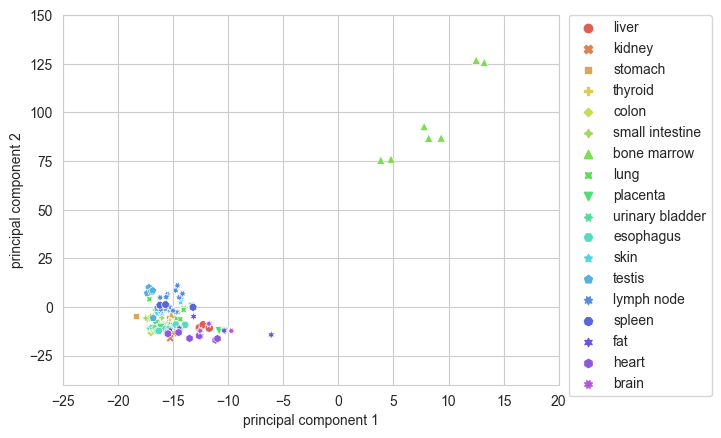

In [20]:
#draw PCA plot
sns.scatterplot(data = finalDf, x = 'principal component 1', y = 'principal component 2', hue = 'index' 
                , palette = sns.color_palette("hls", 22)
               , style = 'index')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim([-25, 20])
plt.ylim([-40, 150])
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/TissueData_splicing_PCA.png", dpi = 600, bbox_inches = "tight")

C:\Users\felix\AppData\Local\Temp\ipykernel_18168\776361530.py:2: UserWarning: The palette list has more values (22) than needed (18), which may not be intended.
  sns.scatterplot(data = finalDf, x = 'principal component 1', y = 'principal component 2', hue = 'index'


(-20.0, 15.0)

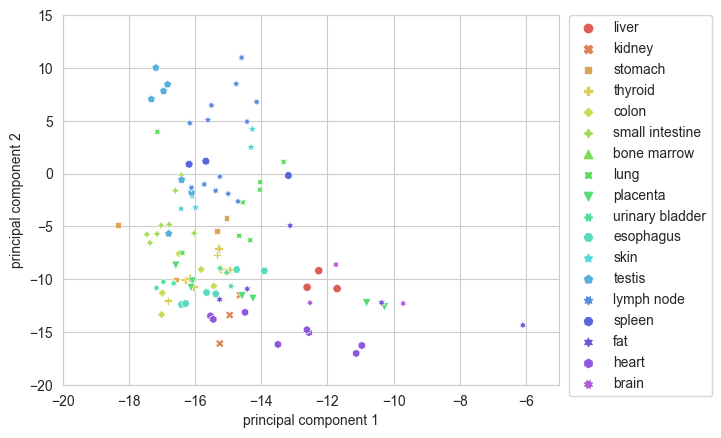

In [21]:
#draw zoomed in PCA plot
sns.scatterplot(data = finalDf, x = 'principal component 1', y = 'principal component 2', hue = 'index' 
                , palette = sns.color_palette("hls", 22)
               , style = 'index')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlim([-20, -5])
plt.ylim([-20, 15])
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/TissueData_splicing_PCA_zoom.png", dpi = 600, bbox_inches = "tight")

# Lollipop plot

Text(0.5, 0, 'PSI')

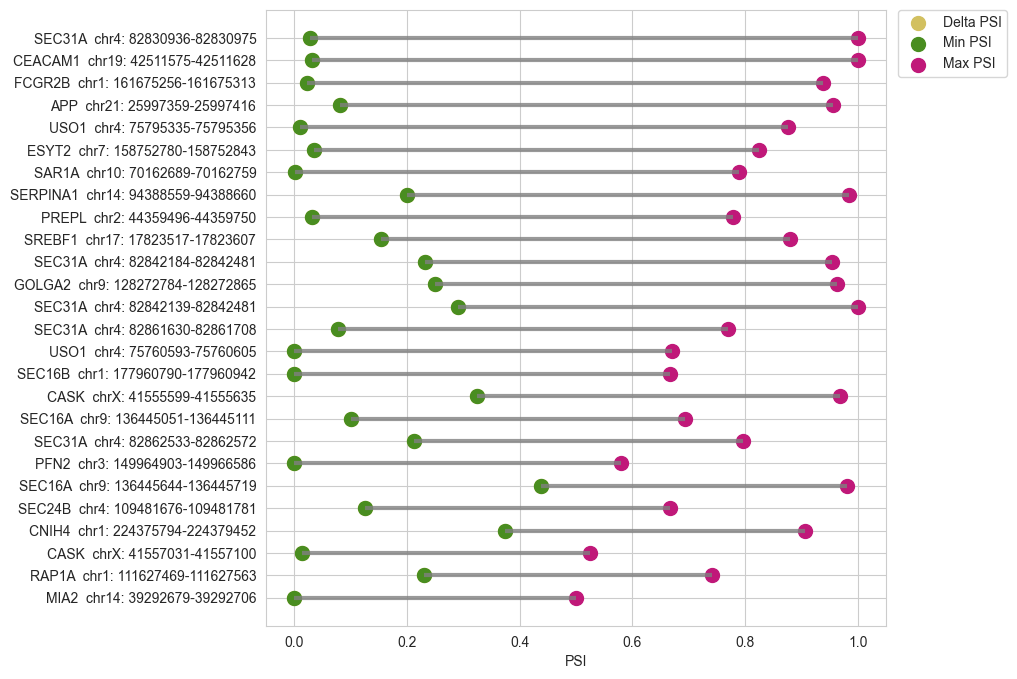

In [22]:
# Create a dataframe with average PSI of all secretory related splice events ofer the tissues
splicing_secretion_lolliplot = mean_data(splicing_secretion)
splicing_secretion_lolliplot = splicing_secretion_lolliplot.drop('PSI_lymphnode_1', axis = 1)

#creating and delta column for sorting by the maximum difference
splicing_secretion_lolliplot['max'] = splicing_secretion_lolliplot.max(axis=1)
splicing_secretion_lolliplot['min'] = splicing_secretion_lolliplot.min(axis=1)
splicing_secretion_lolliplot['delta'] = splicing_secretion_lolliplot['max'] - splicing_secretion_lolliplot['min']
splicing_secretion_lolliplot = splicing_secretion_lolliplot.sort_values(by = 'delta', ascending = False)
#filtering by delta PSI of >0.5, <-0.5
splicing_secretion_lolliplot = splicing_secretion_lolliplot.query('delta > .5 | delta < -.5')

splicing_secretion_lolliplot = splicing_secretion_lolliplot.rename(columns={"PSI_kidney_": "kidney", "PSI_lung_": "lung"
                , 'PSI_skin_': 'skin', 'PSI_testis_' : 'testis', 'PSI_urinarybladder_' : 'urinarybladder'
                , 'PSI_spleen_' : 'spleen', 'PSI_Liver_' : 'liver', 'PSI_smallintestine_' : 'smallintestine'
                , 'PSI_fat_' : 'fat', 'PSI_thyroid_' : 'thyroid', 'PSI_esophagus_' : 'esophagus'
                , 'PSI_brain_' : 'brain', 'PSI_heart_' : 'heart', 'PSI_lymphnode_' : 'lymphnode'
                , 'PSI_placenta_' : 'placenta', 'PSI_stomach_' : 'stomach', 'PSI_Bonemarrow_' : 'bonemarrow'
                , 'PSI_colon_' : 'colon'})
splicing_secretion_lolliplot = splicing_secretion_lolliplot.fillna(0)
splicing_secretion_lolliplot = splicing_secretion_lolliplot.reset_index()
splicing_secretion_lolliplot = splicing_secretion_lolliplot.drop_duplicates(subset='coord_1')
splicing_secretion_lolliplot['coords'] =  splicing_secretion_lolliplot['geneSymbol'] + '  ' + splicing_secretion_lolliplot['coord_chr'] + ': ' + splicing_secretion_lolliplot['coord_1'].astype(str) + '-'  + splicing_secretion_lolliplot['coord_2'].astype(str)
splicing_secretion_lolliplot = splicing_secretion_lolliplot.drop(['geneSymbol', 'strand', 'coord_chr', 'coord_1', 'coord_2',
                                                                  'coord_3', 'coord_4', 'coord_5', 'coord_6', 
                                                                  'Type', 'liver', 'lymphnode', 'brain', 'bonemarrow', 
                                                                  'testis', 'kidney', 'skin', 'stomach', 'colon',
                                                                 'placenta', 'spleen', 'esophagus', 'thyroid', 'lung',
                                                                  'urinarybladder', 'fat', 'smallintestine', 'heart'
                                                                 ],
                                                                 axis = 1)
 
# Reorder it following the values of the first value:
splicing_secretion_lolliplot_ordered = splicing_secretion_lolliplot.sort_values(by='delta')
my_range=range(1,len(splicing_secretion_lolliplot.index)+1)
 
palette_generator = sns.color_palette("PiYG_r", 10)
palette_generator2 =  sns.color_palette("cividis", 5)
# The horizontal plot is made using the hline function
plt.figure(figsize=(8,8))
plt.hlines(y=my_range, xmin=splicing_secretion_lolliplot_ordered['min'],
           xmax=splicing_secretion_lolliplot_ordered['max']
           , color='grey'
           ,alpha=0.8, linewidths = 3)

plt.scatter(splicing_secretion_lolliplot_ordered['min'], my_range, color=palette_generator2[4], alpha=1, label='Delta PSI'
           ,s = 100)
plt.scatter(splicing_secretion_lolliplot_ordered['min'], my_range, color=palette_generator[0], alpha=1, label='Min PSI'
           ,s = 100)
plt.scatter(splicing_secretion_lolliplot_ordered['max'], my_range, color=palette_generator[9], alpha=1 , label='Max PSI'
           ,s = 100)
plt.legend()
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
# Add title and axis names
plt.yticks(my_range, splicing_secretion_lolliplot_ordered['coords'])
plt.xlabel('PSI')

# Show the graph
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/Tissue_secretion_splicing_MINMAX.png", dpi = 600, bbox_inches = "tight")


(0.4, 1.05)

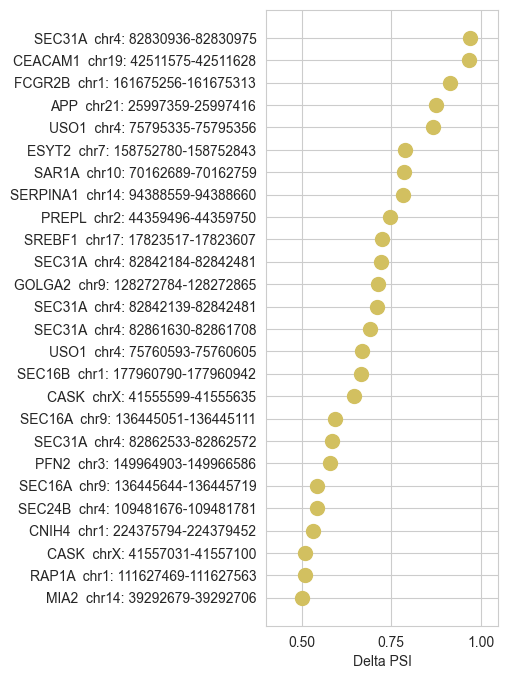

In [23]:
# Reorder it following the values of the first value:
splicing_secretion_lolliplot_ordered = splicing_secretion_lolliplot.sort_values(by='delta')
my_range=range(1,len(splicing_secretion_lolliplot.index)+1)
 
palette_generator = sns.color_palette("PiYG_r", 10)
palette_generator2 =  sns.color_palette("cividis", 5)
# The horizontal plot is made using the hline function
plt.figure(figsize=(3,8))
#plt.legend()
   
plt.scatter(splicing_secretion_lolliplot_ordered['delta'], my_range, color=palette_generator2[4], alpha=1, label='Delta PSI'
           ,s = 100)
# Add title and axis names
plt.yticks(my_range, splicing_secretion_lolliplot_ordered['coords'])
plt.xticks((0.5, 0.75, 1.0))
#plt.title("Comparison of the lowest and the highest PSI per exon", loc='left')
plt.xlabel('Delta PSI')
plt.xlim(0.4,1.05)
#plt.ylabel('coords')

# Show the graph
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/Tissue_secretion_splicing_DELTA.png", dpi = 600, bbox_inches = "tight")

# Exon24c Tissue specific splicing

C:\Users\felix\AppData\Local\Temp\ipykernel_18168\4054062240.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  splicing_E24c  = splicing_secretion.loc['SEC31A', '-', 'chr4', 82830936, 82830975, 82828999, 82829058]
C:\Users\felix\AppData\Local\Temp\ipykernel_18168\4054062240.py:35: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=splicing_E24c.reset_index()


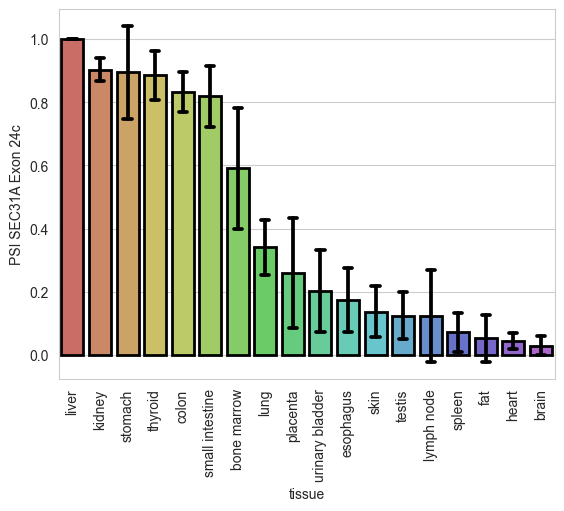

In [24]:
#extract SEC31A exon 24c of the global splicing list
splicing_E24c  = splicing_secretion.loc['SEC31A', '-', 'chr4', 82830936, 82830975, 82828999, 82829058]
splicing_E24c['exon'] = ['E24c_1', 'E24c_3', 'PSI SEC31A Exon 24c']
splicing_E24c = splicing_E24c.reset_index()
splicing_E24c = splicing_E24c.set_index('exon')
splicing_E24c = splicing_E24c.drop(['coord_5', 'coord_6', 'Type'], axis = 1)
splicing_E24c = splicing_E24c.transpose()
splicing_E24c = splicing_E24c.reset_index()
splicing_E24c.columns = ['tissue','E24c_1', 'E24c_3', 'PSI SEC31A Exon 24c']

# remove names from sinlge samples, and replace it with an index of the tissues
string_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'PSI_', '_']
for x in string_list:
    splicing_E24c['tissue'] = splicing_E24c['tissue'].str.replace(x, '')

# homogenize the index    
splicing_E24c = splicing_E24c.replace('Liver', 'liver')
splicing_E24c = splicing_E24c.replace('Bonemarrow', 'bone marrow')
splicing_E24c = splicing_E24c.replace('smallintestine', 'small intestine')
splicing_E24c = splicing_E24c.replace('urinarybladder', 'urinary bladder')
splicing_E24c = splicing_E24c.replace('lymphnode', 'lymph node')

splicing_E24c = splicing_E24c.set_index('tissue')

#create column to sort the samples from mean maximum to mean minimum
list_PSI24c_mean = []
for i in splicing_E24c.transpose():
    list_PSI24c_mean.append(np.mean(splicing_E24c.loc[i]['PSI SEC31A Exon 24c']))
splicing_E24c['PSI24c_mean'] = list_PSI24c_mean
splicing_E24c = splicing_E24c.sort_values(by = 'PSI24c_mean', ascending = False)


# plot the bar plot
palette_generation = sns.color_palette("hls", 22)
sns.barplot(data=splicing_E24c.reset_index()
            , x="tissue", y="PSI SEC31A Exon 24c", ci = "sd", palette=palette_generation
           , linewidth=2, edgecolor="0"
           , errorbar=("pi", 50), capsize=.3, errcolor="0")
plt.tick_params(axis='x', rotation=90)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/SEC31A_E24c_splicing.png", dpi = 600, bbox_inches = "tight")

# Mouse tissue validation

In [25]:
#create DataFrame of the data from the quantification of the radioactive gel
E24csplicing_mousetissues = pd.DataFrame({'PSI 24c' : [ 0.703915241, 0.718047615, 0.710920947
                                                        , 0.432203698, 0.386756401, 0.420612286
                                                        , 0.09155929, 0.097797553, 0.151566682
                                                        , 0.040899208, 0.028932168, 0.000193505
                                                        , 0.145476394, 0.183124488, 0.22928863
                                                        , 0.020357807, 0.046647126, 0.016379024
                                                        ],
                                           'tissue' : ['liver', 'liver','liver',
                                                     'kidney', 'kidney', 'kidney',
                                                    'spleen', 'spleen', 'spleen',
                                                    'lung', 'lung', 'lung',
                                                    'heart', 'heart', 'heart',
                                                    'brain', 'brain', 'brain',
                                                    ]
                                         })
E24csplicing_mousetissues = E24csplicing_mousetissues.set_index('tissue')

In [26]:
#create a DataFrame assigning a color for each tissue, to make the color code consistent
palette_generation = sns.color_palette("hls", 22)
palette_dataframe = pd.DataFrame({'tissue' :  ['liver', 'kidney', 'stomach', 'thyroid', 'colon', 'smallintestine',
                                                    'bonemarrow', 'lung', 'placenta', 
                                                   'urinarybladder', 'esophagus','skin',
                                                   'testis', 'lymphnode', 'spleen','fat', 
                                                   'heart', 'brain'],
                                'color' : palette_generation[0:18]})
palette_dataframe = palette_dataframe.set_index('tissue')

C:\Users\felix\AppData\Local\Temp\ipykernel_18168\4170362917.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=E24csplicing_mousetissues.reset_index(), x="tissue", y="PSI 24c", ci = "sd", palette=palette


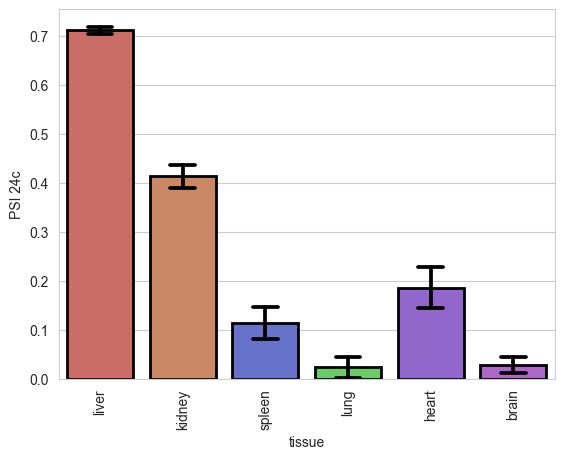

In [27]:
# draw barplot
palette = [palette_dataframe.loc['liver'][0], palette_dataframe.loc['kidney'][0], palette_dataframe.loc['spleen'][0]
          ,palette_dataframe.loc['lung'][0], palette_dataframe.loc['heart'][0], palette_dataframe.loc['brain'][0]]
sns.barplot(data=E24csplicing_mousetissues.reset_index(), x="tissue", y="PSI 24c", ci = "sd", palette=palette
           , linewidth=2, edgecolor="0"
           , errorbar=("pi", 50), capsize=.3, errcolor="0")
plt.tick_params(axis='x', rotation=90)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/SEC31A_E24c_splicing_mouse_validation.png", dpi = 600, bbox_inches = "tight")

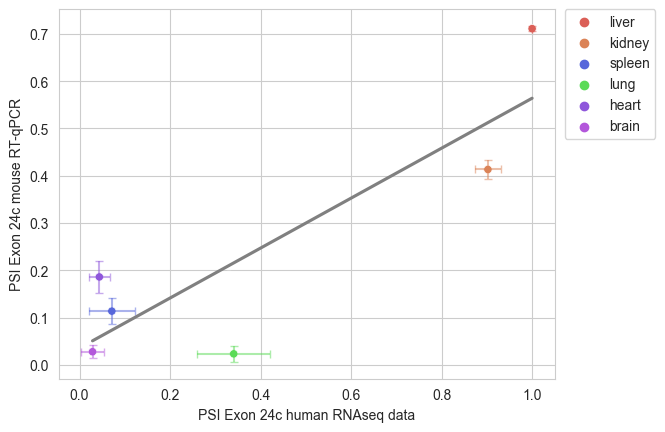

In [28]:
#preparing data for linear regression between mouse and human data
tissue_list = ['liver', 'kidney', 'spleen', 'lung', 'heart', 'brain']
mouse_mean = []
human_mean = []
mouse_std = []
human_std = []
#creating lists for the mean and standart deviasion of exon 24c PSI in mouse and human data
for i in tissue_list:
    mouse_mean.append(np.mean(E24csplicing_mousetissues.loc[i]['PSI 24c']))
    mouse_std.append(np.std(E24csplicing_mousetissues.loc[i]['PSI 24c']))
    human_mean.append(np.mean(splicing_E24c.loc[i]['PSI SEC31A Exon 24c']))
    human_std.append(np.std(splicing_E24c.loc[i]['PSI SEC31A Exon 24c']))

# creating DataFrame of the mouse and human data
E24csplicing_validationplot_mouse = pd.DataFrame({'PSI Exon 24c mouse RT-qPCR' : mouse_mean,
                                                 'mouse_std' : mouse_std,
                                                'tissue' : tissue_list
                                                 })    
E24csplicing_validationplot_human = pd.DataFrame({'PSI Exon 24c human RNAseq data' : human_mean,
                                                 'human_std' : human_std 
                                                 })    
E24csplicing_validationplot = pd.concat([E24csplicing_validationplot_human, E24csplicing_validationplot_mouse]
                                       ,axis = 1)
#plot the y and x error bars in propper color 
for n in range(0,6):
    plt.errorbar(human_mean[n], mouse_mean[n], xerr = human_std[n], yerr=mouse_std[n]
             , fmt="none"
            ,color = palette[n]
             ,capsize = 3
             ,alpha= .5
            )
    
#plot the mean values
sns.scatterplot(data = E24csplicing_validationplot, x = 'PSI Exon 24c human RNAseq data'
                , y = 'PSI Exon 24c mouse RT-qPCR'
                , hue = 'tissue'
                , palette = palette) 

#plot the regression line
sns.regplot(data = E24csplicing_validationplot, x = 'PSI Exon 24c human RNAseq data'
                , y = 'PSI Exon 24c mouse RT-qPCR'
           , marker = ''
           , ci = 0
           , color = 'gray'
           )

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

reg_stats = linregress(E24csplicing_validationplot['PSI Exon 24c human RNAseq data']
                 , E24csplicing_validationplot['PSI Exon 24c mouse RT-qPCR'])

#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/SEC31A_E24c_splicing_mouse_validation_reg.png", dpi = 600, bbox_inches = "tight")

In [20]:
linregress(E24csplicing_validationplot['PSI Exon 24c human RNAseq data']
                 , E24csplicing_validationplot['PSI Exon 24c mouse RT-qPCR'])

LinregressResult(slope=0.5280861518309957, intercept=0.03575084472894954, rvalue=0.872169529993513, pvalue=0.023466528446515405, stderr=0.14810293065735777, intercept_stderr=0.0841726672997845)

# Correlation with Exon24c

In [33]:
#preparing exon 24c alternative splicing data to mach the gene expression DataFrame
splicing_E24c  = splicing_secretion.loc['SEC31A', '-', 'chr4', 82830936, 82830975, 82828999, 82829058, 82842184, 82842481]
splicing_E24c = splicing_E24c.drop(['PSI_Bonemarrow_3', 'PSI_Bonemarrow_7', 'PSI_colon_4','PSI_heart_5', 'PSI_lymphnode_7'
                                   ,'PSI_lymphnode_14', 'PSI_testis_3'
                                    , 'PSI_thyroid_6', 'PSI_lung_7']
                                  , axis = 1)
splicing_E24c = splicing_E24c.transpose()#.reset_index().sort_values(by = 'index').set_index('index')
splicing_E24c.columns = ['SEC31A Exon 24c']
splicing_E24c = splicing_E24c.transpose()

C:\Users\felix\AppData\Local\Temp\ipykernel_18168\3166225626.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  splicing_E24c  = splicing_secretion.loc['SEC31A', '-', 'chr4', 82830936, 82830975, 82828999, 82829058, 82842184, 82842481]


In [34]:
#read in DEseq2 DataFrame with gene counts of all tissues 
genecounts_all = pd.read_csv(PATH + '/RNAseq_Felix/human_tissues/Bioinfo/Deseq/dataframeall.csv', sep=',', index_col=0)
genecounts_all = genecounts_all.reset_index()
genecounts_all = genecounts_all.drop(['liver4', 'liver5', 'bonemarrow8', 'colon6', 'lung7','heart5', 'lymphnode'
                                      , 'ovary1', 'ovary2', 'ovary3'
                                      , 'ovary4',  'bonemarrow9', 'testis3'
                                     ], axis = 1)
genecounts_all = genecounts_all.set_index(['index'])
genecounts_all = genecounts_all.transpose().reset_index().set_index('index').transpose()

In [35]:
#merging SEC31A splicing PSI with gene counts
splicing_E24c.columns = genecounts_all.columns
genecounts_all_Exon24 = pd.concat([splicing_E24c, genecounts_all])
genecounts_all_Exon24

index,liver1,liver2,liver3,bonemarrow1,bonemarrow2,bonemarrow4,bonemarrow5,bonemarrow6,brain1,brain2,...,thyroid5,thyroid7,thyroid8,thyroid9,urinarybladder1,urinarybladder2,urinarybladder3,urinarybladder4,urinarybladder5,urinarybladder6
SEC31A Exon 24c,1.000000,1.000000,1.000000,0.545000,0.489000,0.379000,0.781000,0.790000,0.000000,0.061000,...,0.933000,0.863000,0.760000,0.914000,0.173000,0.236000,0.251000,0.394000,0.000000,0.157000
A1BG,12318.270290,12136.949674,10342.181049,27.130290,29.860847,34.484126,19.068734,9.733075,82.985281,28.944147,...,2.255475,28.605068,13.779485,5.648581,4.220913,11.252394,40.889520,3.645332,13.965598,34.551745
A1CF,10445.483039,10895.979783,6480.191657,0.000000,0.000000,0.000000,0.000000,12.969967,6.743337,0.857933,...,0.521160,0.000000,0.000000,0.909614,0.000000,0.000000,1.776547,0.000000,0.000000,0.000000
A2M,36162.989455,36864.167678,43468.870001,113.603597,117.848225,51.527483,107.560125,76.579175,5110.888592,6960.326345,...,3525.503238,3824.140088,3981.233016,4070.268826,19033.697009,28516.081845,28606.388599,28338.461624,18969.574146,18887.048356
A2ML1,2.261757,4.573931,5.402226,8.950489,5.626251,2.911886,0.000000,8.320939,74.326991,42.239148,...,1.651152,1.976731,0.978510,0.000000,4.455738,4.870450,8.193431,4.310130,6.769040,10.911252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,41.929321,34.739691,110.688411,15.362452,8.188179,9.316624,19.258939,38.458179,5.724445,8.515753,...,93.077066,76.114759,100.931445,112.009145,7.283968,12.540314,10.949918,4.959528,2.830942,5.503627
ZYG11B,1364.521021,1323.240545,1505.045776,197.752052,208.604335,545.265627,489.545425,717.113008,2348.226825,1505.910750,...,1072.498567,943.346764,900.000581,962.847573,578.537645,561.869943,645.523973,571.933275,656.155814,582.780768
ZYX,1779.555571,2183.808436,1048.752294,2385.488538,2533.629595,2859.546254,2849.623332,3061.805006,475.364392,1061.293568,...,717.934365,648.701581,479.114385,771.403399,1252.561115,2698.215902,3499.517388,3393.604720,1238.969836,1380.333255
ZZEF1,507.738754,361.906129,355.564213,1281.927733,1145.973300,2651.627591,2345.892722,2538.253089,702.231676,645.362042,...,1002.566870,965.893023,999.683786,1009.290934,776.703184,863.217252,584.990039,642.038884,862.534507,827.571790


In [36]:
#calculating the pearson correlation between the PSI and Exon 24a and all other genes in all tissues
GE_all = genecounts_all_Exon24
corr_list = []
for i in GE_all.reset_index()['index']:
    Corr_df = pd.DataFrame([genecounts_all_Exon24.loc['SEC31A Exon 24c'], genecounts_all_Exon24.loc[f'{i}']])
    #print(Corr_df.transpose().corr()[f'A3SS'][f'{i}'])
    corr_list.append(Corr_df.transpose().corr(method='pearson')['SEC31A Exon 24c'][f'{i}'])

In [37]:
Correlation = pd.DataFrame(corr_list)
Correlation['Gene_ID'] = GE_all.reset_index()['index']
Correlation.columns = ['pearson_24c', 'GENE_ID']
Correlation = Correlation.set_index('GENE_ID')

C:\Users\felix\anaconda3\envs\RNAseq_env\lib\site-packages\pandas\core\internals\construction.py:568: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array([convert(v) for v in values])


In [38]:
#calculating the spearman correlation between the PSI and Exon 24a and all other genes in all tissues
GE_all = genecounts_all_Exon24
corr_list = []
for i in GE_all.reset_index()['index']:
    Corr_df = pd.DataFrame([genecounts_all_Exon24.loc['SEC31A Exon 24c'], genecounts_all_Exon24.loc[f'{i}']])
    #print(Corr_df.transpose().corr()[f'A3SS'][f'{i}'])
    corr_list.append(Corr_df.transpose().corr(method = 'spearman')['SEC31A Exon 24c'][f'{i}'])
    
Correlation['spearman_24c'] = corr_list

In [39]:
Correlation = Correlation.drop('SEC31A Exon 24c')

In [40]:
Correlation.columns = ['Pearson_correlation', 'Spearman_correlation']

In [41]:
Correlation = Correlation.reset_index()

In [317]:
#Correlation.to_excel(PATH + '/Projects/SEC31A_Exon24c/Correlation.xlsx')

Text(0, 0.5, 'Spearman Correlation')

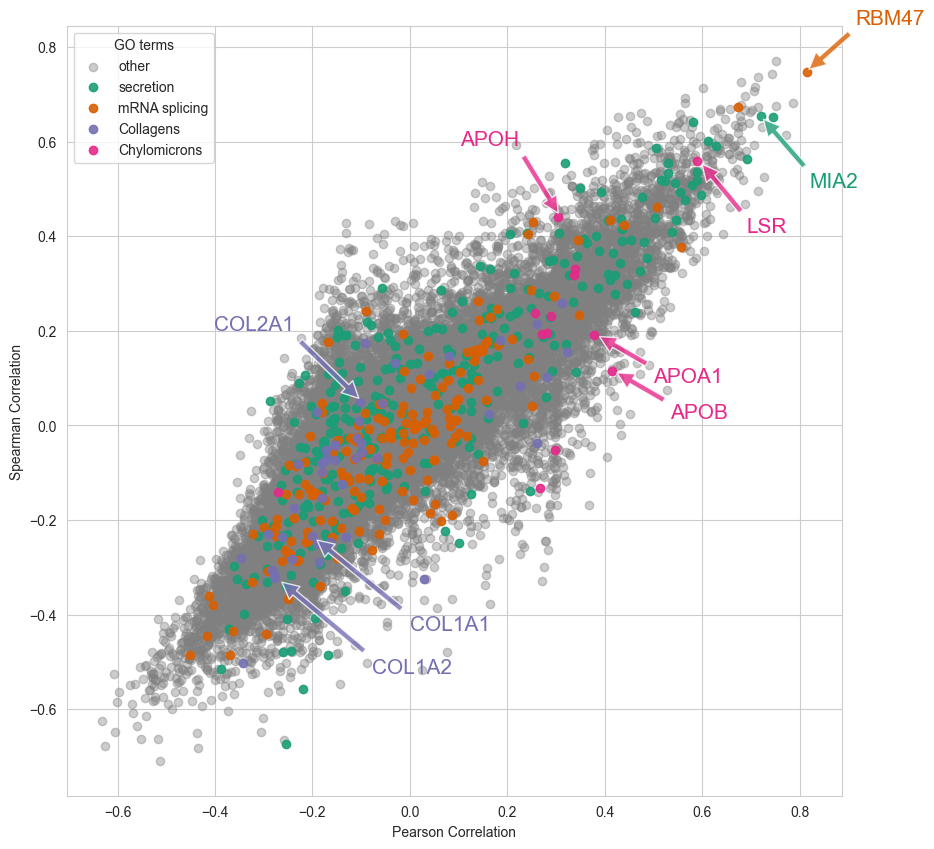

In [43]:
#plotting the correlation with highlighted GO terms

# loading the correltaion list
Correlation = pd.read_excel(PATH + '/Projects/SEC31A_Exon24c/Correlation.xlsx', index_col= 0)
Correlation = Correlation.sort_index(ascending=True)

#loading various GO temr lists 
Collagen_Chylomicrons = pd.read_excel(PATH + '/RNAseq_Felix/GOterm_Lists/Collagen_Chylomicrons.xlsx')

GOsecretion_human2 = pd.read_excel(PATH + '/RNAseq_Felix/GOterm_Lists/GOsecretion_human2.xlsx')
GOsecretion_human2.columns = ['GENE_ID', 'GO_term']

GO_term_RNA_splicing = pd.read_excel(PATH + '/RNAseq_Felix/GOterm_Lists/GO_term_RNA_splicing.xlsx')
GO_term_RNA_splicing.columns = ['GENE_ID', 'GO_term']

GO_terms = pd.concat([GOsecretion_human2, GO_term_RNA_splicing, Collagen_Chylomicrons])
GO_terms = GO_terms.drop_duplicates(subset = 'GENE_ID')

#merge Correlation list and GO term lists
Correlation = Correlation.merge(GO_terms, on = 'GENE_ID', how = 'outer')
Correlation = Correlation.dropna(subset=['Pearson_correlation', 'Spearman_correlation'])
Correlation = Correlation.fillna('other')

Correlation = Correlation.reset_index().drop('index', axis = 1)

#create various color palettes
palette_generation_2 = sns.color_palette("PiYG_r", 20)
palette3 = sns.color_palette("Dark2", 4)

#plot each GO term in a scatter plot
plt.figure(figsize=(10,10))
plt.scatter(data = Correlation.query('GO_term == "other"'), x = 'Pearson_correlation', y = 'Spearman_correlation'
           , color = 'grey', alpha = .4, label = 'other')
plt.scatter(data = Correlation.query('GO_term == "secretion"'), x = 'Pearson_correlation', y = 'Spearman_correlation'
           , color = palette3[0], alpha = .9, label = 'secretion')
plt.scatter(data = Correlation.query('GO_term == "mRNA splicing"'), x = 'Pearson_correlation', y = 'Spearman_correlation'
           , color = palette3[1], alpha = .9, label = 'mRNA splicing')

plt.scatter(data = Correlation.query('GO_term == "Collagens"'), x = 'Pearson_correlation', y = 'Spearman_correlation'
           , color = palette3[2], alpha = .9, label = 'Collagens')
plt.scatter(data = Correlation.query('GO_term == "Chylomicrons"'), x = 'Pearson_correlation', y = 'Spearman_correlation'
           , color = palette3[3], alpha = .9, label = 'Chylomicrons')

#plot legend
plt.legend(loc='best', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
plt.legend(title='GO terms')

#mark highlighted genes with error and gene name
text = Correlation['GENE_ID']
for i, label in enumerate(text):
    if text[i] == 'RBM47':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.00, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]+.1, Correlation['Spearman_correlation'][i]+0.1)
                     , size=15, color = palette3[1],
                    arrowprops=dict(facecolor=palette3[1]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
    if text[i] == 'MIA2':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.00, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]+.1, Correlation['Spearman_correlation'][i]-.15)
                     , size=15, color = palette3[0],
                    arrowprops=dict(facecolor=palette3[0]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
        
    if text[i] == 'LSR':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.005, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]+.1, Correlation['Spearman_correlation'][i]-.15)
                     , size=15, color = palette3[3],
                    arrowprops=dict(facecolor=palette3[3]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
    if text[i] == 'APOB':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.005, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]+.12, Correlation['Spearman_correlation'][i]-.1)
                     , size=15, color = palette3[3],
                    arrowprops=dict(facecolor=palette3[3]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
    if text[i] == 'APOA1':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.005, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]+.12, Correlation['Spearman_correlation'][i]-.1)
                     , size=15, color = palette3[3],
                    arrowprops=dict(facecolor=palette3[3]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
    if text[i] == 'APOH':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.005, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]-.2, Correlation['Spearman_correlation'][i]+.15)
                     , size=15, color = palette3[3],
                    arrowprops=dict(facecolor=palette3[3]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
        
    if text[i] == 'COL1A1':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.000, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]+.2, Correlation['Spearman_correlation'][i]-.2)
                     , size=15, color = palette3[2],
                    arrowprops=dict(facecolor=palette3[2]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
        
    if text[i] == 'COL1A2':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.005, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]+.2, Correlation['Spearman_correlation'][i]-.2)
                     , size=15, color = palette3[2],
                    arrowprops=dict(facecolor=palette3[2]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))
        
    if text[i] == 'COL2A1':
        plt.annotate(text[i],  xy = (Correlation['Pearson_correlation'][i]+0.005, Correlation['Spearman_correlation'][i])
                     , xytext = (Correlation['Pearson_correlation'][i]-.3, Correlation['Spearman_correlation'][i]+.15)
                     , size=15, color = palette3[2],
                    arrowprops=dict(facecolor=palette3[2]
                                    , shrink=0.05
                                    , alpha = .8
                                   ))

plt.xlabel("Pearson Correlation")
plt.ylabel("Spearman Correlation")

#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/SEC31A_E24c_GE_correlation_2.png", dpi = 600, bbox_inches = "tight")


In [44]:
#preparing Splicing data and gene epxression data to be ploted in linear regression
genecounts_all_Exon24_transpose = genecounts_all_Exon24.transpose().reset_index()
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('1', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('2', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('3', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('4', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('5', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('6', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('7', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('8', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('9', '')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].str.replace('0', '')

genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].replace('Bonemarrow', 'bone marrow')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].replace('smallintestine', 'small intestine')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].replace('urinarybladder', 'urinary bladder')
genecounts_all_Exon24_transpose['index'] = genecounts_all_Exon24_transpose['index'].replace('lymphnode', 'lymph node')

list_PSI24c_mean = []
for i in genecounts_all_Exon24_transpose.set_index('index').transpose():
    list_PSI24c_mean.append(np.mean(genecounts_all_Exon24_transpose.set_index('index').loc[i]['SEC31A Exon 24c']))
genecounts_all_Exon24_transpose['PSI24c_mean'] = list_PSI24c_mean
genecounts_all_Exon24_transpose = genecounts_all_Exon24_transpose.sort_values(by = 'PSI24c_mean', ascending = False)
genecounts_all_Exon24_transpose


,index,SEC31A Exon 24c,A1BG,A1CF,A2M,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,PSI24c_mean
0,liver,1.000,12318.270290,10445.483039,36162.989455,2.261757,2.736481,0.000000,20.755726,0.000000,...,42.713204,72.693124,865.942068,388.077714,41.929321,1364.521021,1779.555571,507.738754,568.525140,1.000000
2,liver,1.000,10342.181049,6480.191657,43468.870001,5.402226,22.392268,0.000000,15.851243,1.189285,...,155.386060,56.798168,506.049467,329.393555,110.688411,1505.045776,1048.752294,355.564213,621.558292,1.000000
1,liver,1.000,12136.949674,10895.979783,36864.167678,4.573931,11.066301,0.000000,17.509912,0.000000,...,22.287299,60.426997,882.500430,395.996000,34.739691,1323.240545,2183.808436,361.906129,403.357604,1.000000
36,kidney,0.863,34.863597,206.022202,11187.141169,0.000000,10.232725,0.000000,232.269803,3.122770,...,105.057047,75.110241,214.206575,329.660449,44.142129,677.315115,871.807461,853.259532,433.258465,0.902333
35,kidney,0.934,18.774889,1218.653637,7989.913273,0.000000,4.141515,0.669392,490.126584,5.318990,...,69.409381,92.836869,202.410190,368.570264,93.319978,1239.382962,624.390540,857.305871,550.829494,0.902333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,heart,0.055,5.028393,0.000000,14182.746997,1.156133,13.309353,0.000000,673.054840,1.345865,...,28.405172,99.632734,169.387081,220.038818,6.149323,1491.657174,1334.101931,779.783391,426.905835,0.043750
28,heart,0.073,38.320874,0.000000,13819.880242,24.755843,12.149726,0.000000,289.019797,1.209262,...,20.855281,76.003070,172.005533,276.469057,9.784944,1241.460377,1193.640910,1163.420161,450.119972,0.043750
10,brain,0.025,25.829639,0.317665,3403.414636,123.246202,12.812483,0.000000,10.114597,0.866018,...,62.956272,104.826841,269.091711,301.584554,5.435589,801.505802,754.275496,1089.385990,386.849898,0.028667
9,brain,0.061,28.944147,0.857933,6960.326345,42.239148,6.355490,2.052424,39.859276,2.318948,...,82.267178,80.660852,224.824962,218.943255,8.515753,1505.910750,1061.293568,645.362042,391.612992,0.028667


C:\Users\felix\AppData\Local\Temp\ipykernel_18168\3311728826.py:5: UserWarning: The palette list has more values (22) than needed (18), which may not be intended.
  sns.scatterplot(data = genecounts_all_Exon24_transpose, x = f'{x}', y = f'{y}', hue = 'index',  style = 'index' ,


LinregressResult(slope=1525.9402070946876, intercept=210.54029918763558, rvalue=0.7201673440122337, pvalue=1.0049154190595335e-17, stderr=146.27764228855523, intercept_stderr=76.15162215385146)


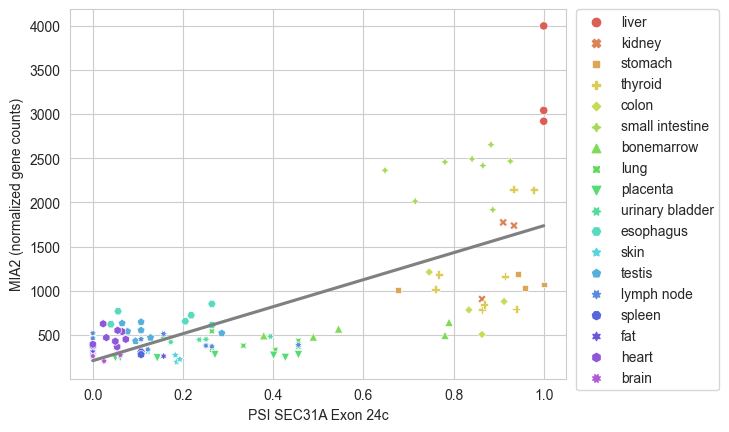

In [45]:
#plot linear regression
x = 'SEC31A Exon 24c'
y = 'MIA2'
sns.regplot(data = genecounts_all_Exon24_transpose, x = f'{x}', y = f'{y}', marker='', ci = 0, color = 'gray')
sns.scatterplot(data = genecounts_all_Exon24_transpose, x = f'{x}', y = f'{y}', hue = 'index',  style = 'index' ,
                palette = sns.color_palette("hls", 22)).set(xlabel = 'PSI SEC31A Exon 24c', 
                                                            ylabel = 'MIA2 (normalized gene counts)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

reg_stats = linregress(genecounts_all_Exon24_transpose.dropna()[f'{x}']
                 , genecounts_all_Exon24_transpose.dropna()[f'{y}'])
print(reg_stats)                                 
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/24c_MIA2_corr.png", dpi = 600, bbox_inches = "tight")

C:\Users\felix\AppData\Local\Temp\ipykernel_18168\600550445.py:5: UserWarning: The palette list has more values (22) than needed (18), which may not be intended.
  sns.scatterplot(data = genecounts_all_Exon24_transpose, x = f'{x}', y = f'{y}', hue = 'index',  style = 'index' ,


LinregressResult(slope=2305.2344355847777, intercept=124.9964872399554, rvalue=0.8136894041930187, pvalue=1.5507543968766566e-25, stderr=163.86869159693902, intercept_stderr=85.30946007948107)


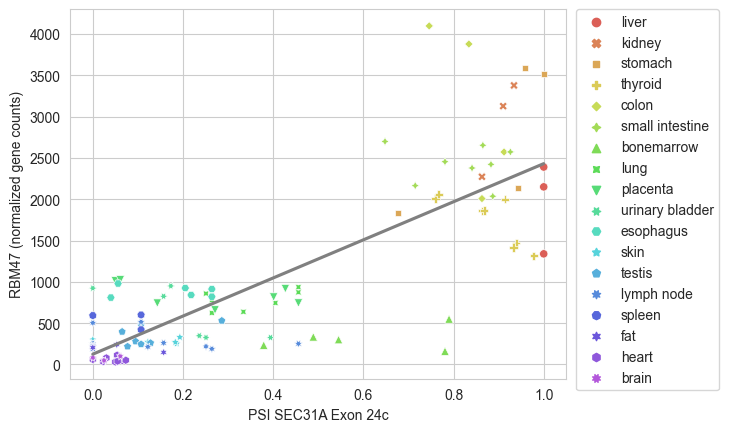

In [47]:
#plot linear regression
x = 'SEC31A Exon 24c'
y = 'RBM47'
sns.regplot(data = genecounts_all_Exon24_transpose, x = f'{x}', y = f'{y}', marker="", ci = 0, color = 'gray')
sns.scatterplot(data = genecounts_all_Exon24_transpose, x = f'{x}', y = f'{y}', hue = 'index',  style = 'index' ,
                palette = sns.color_palette("hls", 22)).set(xlabel = 'PSI SEC31A Exon 24c', 
                                                            ylabel = 'RBM47 (normalized gene counts)')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

reg_stats = linregress(genecounts_all_Exon24_transpose.dropna()[f'{x}']
                 , genecounts_all_Exon24_transpose.dropna()[f'{y}'])
print(reg_stats)                                 
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/24c_RBM47_corr.png", dpi = 600, bbox_inches = "tight")

The data is not normaly distributed, so the  Mann-Whitney U test was performed
Pvalue: 1.1019457081009791e-05
Cohen´s d: 2.096293168750461


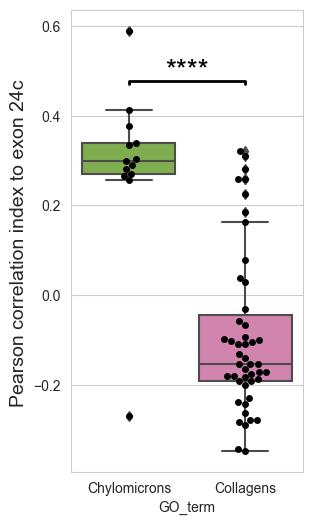

In [79]:
y_limit = .50
DATA = Correlation.query('GO_term !="other"').query('GO_term != "secretion"').query('GO_term != "mRNA splicing"')

x_data = 'GO_term'
y_data = 'Pearson_correlation'
group1 = DATA.query('GO_term == "Chylomicrons"')[y_data]
group2 = DATA.query('GO_term == "Collagens"')[y_data]


plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.boxplot(data= DATA, x = x_data, y = y_data, palette = ['#7fbc41', '#de77ae']
           # ,capsize = 0.2,             
           # saturation = 8,             
           # errcolor = 'black', errwidth = 2,
           # linewidth=2, edgecolor="0"
                  )

#statistics
p_test = statistic_f(group1, group2)

#calculating Cohen´s d
cohensd = cohens_d(group1, group2)

#statistics depiction with asterisks
asterisk_text = statistic_asterisk(p_test)
    
x1, x2 = 0, 1   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text, ha='center', va='bottom', color=col, size = 20)
plot.set_ylabel("Pearson correlation index to exon 24c ", fontsize=14)
print('Pvalue: ' + str(p_test))
print('Cohen´s d: ' + str(cohensd))
#plt.savefig(PATH + "/Projects/SEC31A_Exon24c/Figures/E24c_corr_APO_COL.png", dpi=600, bbox_inches='tight')


# RBM47 KO RNAseq

In [80]:
RBM47_KO_SE = pd.read_excel(PATH + '/RNAseq_Felix/RBM47/RMATS/CTRLvsRBM47KD/SE_CTRLvsRBM47KD.xlsx',
                           index_col = [2,3,4,5,6,7,8,9,10])

In [81]:
RBM47_KO_E24c = RBM47_KO_SE.loc['SEC31A', 'chr4', '-', 82830936, 82830975, 82828999, 82829058, 82842139]
RBM47_KO_E24c = RBM47_KO_E24c.drop(['Unnamed: 0', 'GeneID', 'PValueCTRLvsRBM47KD', 'DPSI_CTRLvsRBM47KD'], axis = 1)
RBM47_KO_E24c_plot = RBM47_KO_E24c.transpose().reset_index()
RBM47_KO_E24c_plot = RBM47_KO_E24c_plot.replace('PSI_CTRL_1', 'Ctrl')
RBM47_KO_E24c_plot = RBM47_KO_E24c_plot.replace('PSI_CTRL_2', 'Ctrl')
RBM47_KO_E24c_plot = RBM47_KO_E24c_plot.replace('PSI_CTRL_3', 'Ctrl')
RBM47_KO_E24c_plot = RBM47_KO_E24c_plot.replace('PSI_RBM47KD_1', 'RBM47 KD')
RBM47_KO_E24c_plot = RBM47_KO_E24c_plot.replace('PSI_RBM47KD_2', 'RBM47 KD')
RBM47_KO_E24c_plot = RBM47_KO_E24c_plot.replace('PSI_RBM47KD_3', 'RBM47 KD')
RBM47_KO_E24c_plot.columns = ['treatment', 'PSI_E24c']

C:\Users\felix\AppData\Local\Temp\ipykernel_18168\2640690897.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  RBM47_KO_E24c = RBM47_KO_SE.loc['SEC31A', 'chr4', '-', 82830936, 82830975, 82828999, 82829058, 82842139]


The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue: 0.002183741559785605
Cohen´s d: 7.007164341777353


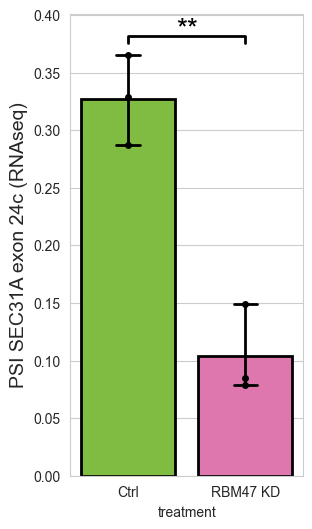

In [82]:
y_limit = .40
DATA = RBM47_KO_E24c_plot


x_data = 'treatment'
y_data = 'PSI_E24c'
group1 = RBM47_KO_E24c_plot.query('treatment == "Ctrl"')[y_data]
group2 = RBM47_KO_E24c_plot.query('treatment == "RBM47 KD"')[y_data]


plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data, palette = ['#7fbc41', '#de77ae']
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics
p_test = statistic_f(group1, group2)

#calculating Cohen´s d
cohensd = cohens_d(group1, group2)

#statistics depiction with asterisks
asterisk_text = statistic_asterisk(p_test)
    
x1, x2 = 0, 1   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text, ha='center', va='bottom', color=col, size = 20)
plot.set_ylabel("PSI SEC31A exon 24c (RNAseq)", fontsize=14)
print('Pvalue: ' + str(p_test))
print('Cohen´s d: ' + str(cohensd))
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/E24c_splicing_RBM47KD_predicted.png", dpi=600, bbox_inches='tight')

In [83]:
genecounts_all_RBM47KD = pd.read_csv(PATH + '/RNAseq_Felix/RBM47/Deseq/dataframe_CTRLvsRBM47KD.csv', sep=',', index_col=0)
genecounts_RBM47KD = genecounts_all_RBM47KD.loc['RBM47']
genecounts_RBM47KD = genecounts_RBM47KD.transpose().reset_index()
genecounts_RBM47KD = genecounts_RBM47KD.replace('CTRL_1', 'Ctrl')
genecounts_RBM47KD = genecounts_RBM47KD.replace('CTRL_2', 'Ctrl')
genecounts_RBM47KD = genecounts_RBM47KD.replace('CTRL_3', 'Ctrl')
genecounts_RBM47KD = genecounts_RBM47KD.replace('RBM47KD_1', 'RBM47 KD')
genecounts_RBM47KD = genecounts_RBM47KD.replace('RBM47KD_2', 'RBM47 KD')
genecounts_RBM47KD = genecounts_RBM47KD.replace('RBM47KD_3', 'RBM47 KD')
genecounts_RBM47KD.columns = ['treatment', 'GE_RBM47']
genecounts_RBM47KD

,treatment,GE_RBM47
0,Ctrl,8890.166707
1,Ctrl,9349.718589
2,Ctrl,9270.651325
3,RBM47 KD,1484.312725
4,RBM47 KD,1463.927944
5,RBM47 KD,1545.288598


The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue: 7.416599750034096e-07
Cohen´s d: 53.30058695646919


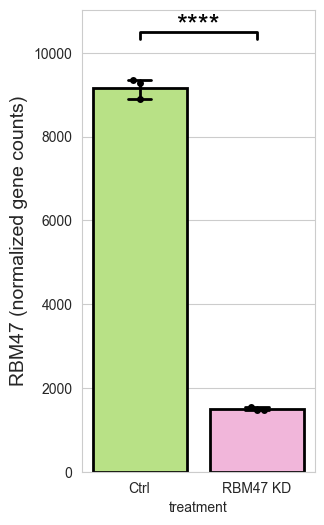

In [84]:
DATA = genecounts_RBM47KD
y_limit = 11000
x_data = 'treatment'
y_data = 'GE_RBM47'
group1 = DATA.query('treatment == "Ctrl"')[y_data]
group2 = DATA.query('treatment == "RBM47 KD"')[y_data]



plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data, palette = ['#b8e186', '#f1b6da']
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")
#statistics
p_test = statistic_f(group1, group2)

#calculating Cohen´s d
cohensd = cohens_d(group1, group2)

#statistics depiction with asterisks
asterisk_text = statistic_asterisk(p_test)
    
x1, x2 = 0, 1   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text, ha='center', va='bottom', color=col, size = 20)
plot.set_ylabel("RBM47 (normalized gene counts)", fontsize=14)
print('Pvalue: ' + str(p_test))
print('Cohen´s d: ' + str(cohensd))
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/RBM47_GE_RBM47KD_predicted.png", dpi=600, bbox_inches='tight')

# RBM47 gene expression validation

In [85]:
RBM47GE_mousetissues = pd.DataFrame({'GE_RBM47' : [0.367292, 0.158769, 0.156583,
                                                    0.17254, 0.264255,
                                                    0.090873, 0.088083, 0.029462,
                                                    0.092783, 0.092783, 0.096723,
                                                    0.033609, 0.005263, 0.00879,
                                                    0.002971, 0.001724, 0.002036
                                                    ],
                                           'tissue' : ['liver', 'liver', 'liver',
                                                'kidney', 'kidney',
                                                'spleen', 'spleen', 'spleen',
                                                'lung', 'lung', 'lung',
                                                'heart', 'heart','heart',
                                                'brain', 'brain', 'brain'
                                                    ]
                                         })
RBM47GE_mousetissues = RBM47GE_mousetissues.set_index('tissue')

In [86]:
genecounts_all = pd.read_csv(PATH + '/RNAseq_Felix/human_tissues/Bioinfo/Deseq/dataframeall.csv', sep=',', index_col=0)
genecounts_all_RBM47 = pd.DataFrame(genecounts_all.loc['RBM47'])
genecounts_all_RBM47 = genecounts_all_RBM47.reset_index()
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('1', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('2', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('3', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('4', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('5', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('6', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('7', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('8', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('9', '')
genecounts_all_RBM47['index'] = genecounts_all_RBM47['index'].str.replace('0', '')
genecounts_all_RBM47.columns = ['tissue', 'RBM47']
genecounts_all_RBM47 = genecounts_all_RBM47.set_index('tissue')

LinregressResult(slope=8.106779601850719e-05, intercept=0.0223646905286983, rvalue=0.921117687558769, pvalue=0.009088209415742572, stderr=1.713050044857797e-05, intercept_stderr=0.024567737290318258)


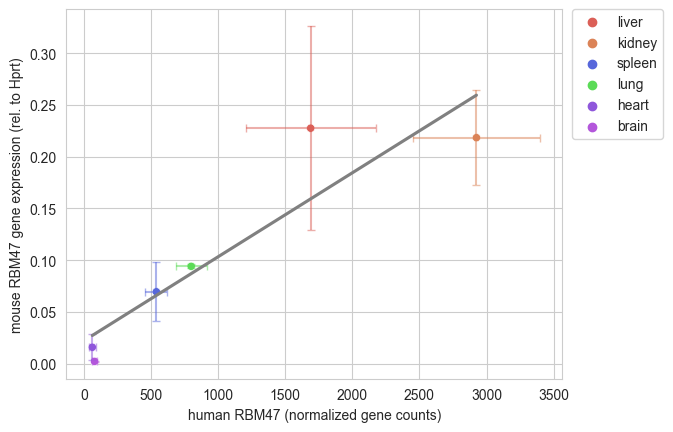

In [87]:
#E24csplicing_mousetissues = E24csplicing_mousetissues.set_index('tissue') 
tissue_list = ['liver', 'kidney', 'spleen', 'lung', 'heart', 'brain']
mouse_RBM47_mean = []
human_RBM47_mean = []
mouse_RBM47_std = []
human_RBM47_std = []
for i in tissue_list:
    mouse_RBM47_mean.append(np.mean(RBM47GE_mousetissues.loc[i]['GE_RBM47']))
    mouse_RBM47_std.append(np.std(RBM47GE_mousetissues.loc[i]['GE_RBM47']))
    human_RBM47_mean.append(np.mean(genecounts_all_RBM47.loc[i]['RBM47']))
    human_RBM47_std.append(np.std(genecounts_all_RBM47.loc[i]['RBM47']))
    
RBM47GE_validationplot_mouse = pd.DataFrame({'RBM47_GE_mouse_validation' : mouse_RBM47_mean,
                                                 'mouse_std' : mouse_RBM47_std,
                                                'tissue' : tissue_list,
                                                 #'organism' : 'mouse' 
                                                 })    
RBM47GE_validationplot_human = pd.DataFrame({'RBM47_GE_human_prediction' : human_RBM47_mean,
                                                 'human_std' : human_RBM47_std,
                                               # 'tissue' : tissue_list,
                                                 #'organism' : 'human' 
                                                 })    
RBM47GE_validationplot = pd.concat([RBM47GE_validationplot_human, RBM47GE_validationplot_mouse]
                                       ,axis = 1)
for n in range(0,6):
    plt.errorbar(human_RBM47_mean[n], mouse_RBM47_mean[n], xerr = human_RBM47_std[n], yerr=mouse_RBM47_std[n]
             , fmt="none"
            ,color = palette[n]
             ,capsize = 3
             ,alpha= .5
            )

sns.regplot(data = RBM47GE_validationplot, x = 'RBM47_GE_human_prediction'
                , y = 'RBM47_GE_mouse_validation'
           , marker = ''
           , ci = 0
           , color = 'gray'
           ).set(xlabel = 'human RBM47 (normalized gene counts)'
                                         , ylabel = 'mouse RBM47 gene expression (rel. to Hprt)')

sns.scatterplot(data = RBM47GE_validationplot, x = 'RBM47_GE_human_prediction'
                , y = 'RBM47_GE_mouse_validation'
                , hue = 'tissue'
                , palette = palette).set(xlabel = 'human RBM47 (normalized gene counts)'
                                         , ylabel = 'mouse RBM47 gene expression (rel. to Hprt)')

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

reg_stats = linregress(RBM47GE_validationplot['RBM47_GE_human_prediction']
                 , RBM47GE_validationplot['RBM47_GE_mouse_validation'])
print(reg_stats)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/RBM47_GE_mouse_validation_reg.png", dpi = 600, bbox_inches = "tight")


# Mouse tisse RBM47 GE E24c splicing

In [88]:
E24csplicing_mousetissues = pd.DataFrame({'PSI 24c' : [ 0.703915241, 0.718047615, 0.710920947
                                                        , 0.432203698, 0.386756401, 0.420612286
                                                        , 0.09155929, 0.097797553, 0.151566682
                                                        , 0.040899208, 0.028932168, 0.000193505
                                                        , 0.145476394, 0.183124488, 0.22928863
                                                        , 0.020357807, 0.046647126, 0.016379024
                                                        ],
                                           'tissue' : ['liver', 'liver','liver',
                                                     'kidney', 'kidney', 'kidney',
                                                    'spleen', 'spleen', 'spleen',
                                                    'lung', 'lung', 'lung',
                                                    'heart', 'heart', 'heart',
                                                    'brain', 'brain', 'brain',
                                                    ]
                                         })
E24csplicing_mousetissues = E24csplicing_mousetissues.set_index('tissue')

RBM47GE_mousetissues = pd.DataFrame({'GE_RBM47' : [0.367292, 0.158769, 0.156583,
                                                    0.17254, 0.264255,
                                                    0.090873, 0.088083, 0.029462,
                                                    0.092783, 0.092783, 0.096723,
                                                    0.033609, 0.005263, 0.00879,
                                                    0.002971, 0.001724, 0.002036
                                                    ],
                                           'tissue' : ['liver', 'liver', 'liver',
                                                'kidney', 'kidney',
                                                'spleen', 'spleen', 'spleen',
                                                'lung', 'lung', 'lung',
                                                'heart', 'heart','heart',
                                                'brain', 'brain', 'brain'
                                                    ]
                                         })
RBM47GE_mousetissues = RBM47GE_mousetissues.set_index('tissue')

LinregressResult(slope=2.320929095061947, intercept=0.0030286642219939375, rvalue=0.842468529589478, pvalue=0.03526958283875077, stderr=0.7420990798550334, intercept_stderr=0.10202786160847051)


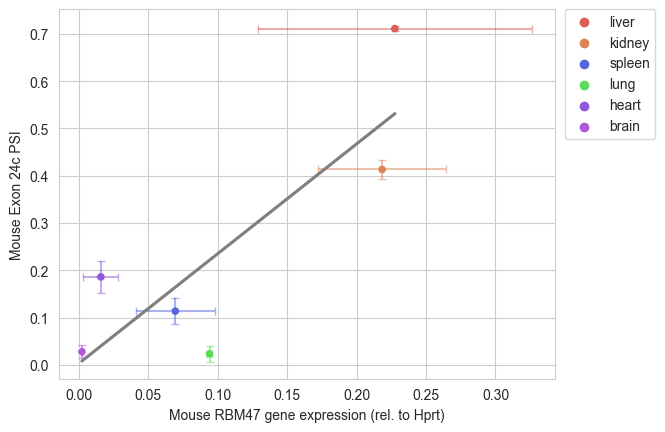

In [90]:
#E24csplicing_mousetissues = E24csplicing_mousetissues.set_index('tissue') 
tissue_list = ['liver', 'kidney', 'spleen', 'lung', 'heart', 'brain']
splicing_mean = []
GE_mean = []
splicing_std = []
GE_std = []
for i in tissue_list:
    splicing_mean.append(np.mean(E24csplicing_mousetissues.loc[i]['PSI 24c']))
    splicing_std.append(np.std(E24csplicing_mousetissues.loc[i]['PSI 24c']))
    GE_mean.append(np.mean(RBM47GE_mousetissues.loc[i]['GE_RBM47']))
    GE_std.append(np.std(RBM47GE_mousetissues.loc[i]['GE_RBM47']))
    
E24csplicing_validationplot_mouse = pd.DataFrame({'Mouse Exon 24c PSI' : splicing_mean,
                                                 'splicing_std' : splicing_std,
                                                'tissue' : tissue_list,
                                                 #'organism' : 'mouse' 
                                                 })    
E24csplicing_validationplot_human = pd.DataFrame({'Mouse RBM47 gene expression (rel. to Hprt)' : GE_mean,
                                                 'GE_std' : GE_std,
                                               # 'tissue' : tissue_list,
                                                 #'organism' : 'human' 
                                                 })    
E24csplicing_validationplot = pd.concat([E24csplicing_validationplot_human, E24csplicing_validationplot_mouse]
                                       ,axis = 1)
for n in range(0,6):
    plt.errorbar(GE_mean[n], splicing_mean[n], xerr = GE_std[n], yerr=splicing_std[n]
             , fmt="none"
            ,color = palette[n]
             ,capsize = 3
             ,alpha= .5
            )
#plt.scatter(splicing_mean, GE_mean)
sns.scatterplot(data = E24csplicing_validationplot, x = 'Mouse RBM47 gene expression (rel. to Hprt)'
                , y = 'Mouse Exon 24c PSI'
                , hue = 'tissue'
                , palette = palette) 
sns.regplot(data = E24csplicing_validationplot, x = 'Mouse RBM47 gene expression (rel. to Hprt)'
                , y = 'Mouse Exon 24c PSI'
           , marker = ''
           , ci = 0
           , color = 'gray'
           )

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

reg_stats = linregress(E24csplicing_validationplot['Mouse RBM47 gene expression (rel. to Hprt)']
                 , E24csplicing_validationplot['Mouse Exon 24c PSI'])
print(reg_stats)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/E24c_splicing_RBM47_GE_mouse.png", dpi = 600, bbox_inches = "tight")



# RBM47 over expression

In [91]:
E24c_splicing_RBM47_OE = pd.DataFrame({'PSI_E24c' : [0.0141585, 0.012621038,
                                                    0.164037232, 0.086022517, 0.138930506
                                                    ],
                                           'treatment' : ['Hek Ctrl', 'Hek Ctrl',
                                                'Hek RBM47 OE', 'Hek RBM47 OE', 'Hek RBM47 OE' 
                                                
                                                
                                                    ]
                                         })

In [92]:
palette_generation_3 = sns.color_palette("RdGy_r", 5)
print(palette_generation_3)
palette_generation_3

[(0.4491349480968859, 0.4491349480968859, 0.4491349480968859), (0.7790849673202616, 0.7790849673202616, 0.7790849673202616), (0.9998462129950019, 0.9972318339100346, 0.9956939638600538), (0.9686274509803922, 0.7176470588235294, 0.6), (0.7893886966551327, 0.2768166089965398, 0.2549019607843137)]


[(0.4491349480968859, 0.4491349480968859, 0.4491349480968859),
 (0.7790849673202616, 0.7790849673202616, 0.7790849673202616),
 (0.9998462129950019, 0.9972318339100346, 0.9956939638600538),
 (0.9686274509803922, 0.7176470588235294, 0.6),
 (0.7893886966551327, 0.2768166089965398, 0.2549019607843137)]

The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 0.029596001019408576
Cohen´s d 1: -5.05558385163618


Text(-4.902777777777777, 0.5, 'PSI exon 24c')

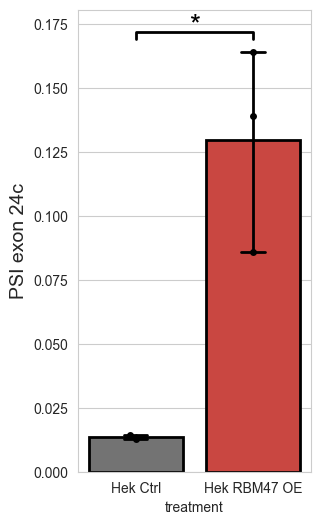

In [93]:
palette_generation_3 = sns.color_palette("RdGy_r", 5)
DATA = E24c_splicing_RBM47_OE
y_limit = 0.18
x_data = 'treatment'
y_data = 'PSI_E24c'
group1 = E24c_splicing_RBM47_OE.query('treatment == "Hek Ctrl"')[y_data]
group2 = E24c_splicing_RBM47_OE.query('treatment == "Hek RBM47 OE"')[y_data]

plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation_3[0],
                        palette_generation_3[4],
                        ]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics1
p_ttest_1 = statistic_f(group1, group2)
cohensd_1 = cohens_d(group1, group2)

#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest_1)
x1, x2 = [0, 1]   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)

#print(stat_text)
print('Pvalue1: ' + str(p_ttest_1))
print('Cohen´s d 1: ' + str(cohensd_1))

plot.set_ylabel("PSI exon 24c", fontsize=14)
#plt.savefig("C:/Users/felix/Documents/Phd/Projects/SEC31A_Exon24c/Figures/E24c_splicing_RBM47_OE.png", dpi=600, bbox_inches='tight')

# Quantification RBM47 overexpression

The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 0.00022800531555446126
Cohen´s d 1: -12.605212388530052


Text(-1.0277777777777768, 0.5, 'RBM47 expression (rel. to GAPDH)')

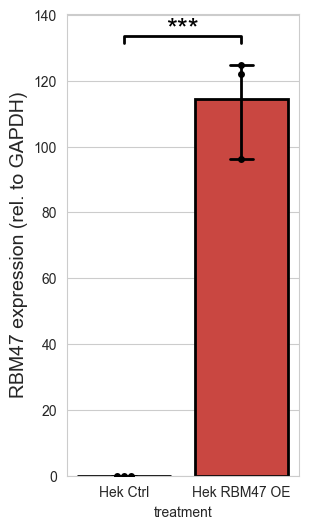

In [99]:
GE_RBM47_OE_quantification = pd.DataFrame({'PSI_E24c' : [0.015356572,
                                                                    0.019572882,
                                                                    0.020545981,
                                                                    124.9320654,
                                                                    121.9376637,
                                                                    96.33579183
                                                    ],
                                           'treatment' : ['Hek Ctrl', 'Hek Ctrl', 'Hek Ctrl',
                                                'Hek RBM47 OE', 'Hek RBM47 OE', 'Hek RBM47 OE']
                                         })

palette_generation_3 = sns.color_palette("RdGy_r", 5)
DATA = GE_RBM47_OE_quantification
y_limit = 140
x_data = 'treatment'
y_data = 'PSI_E24c'
group1 = DATA.query('treatment == "Hek Ctrl"')[y_data]
group2 = DATA.query('treatment == "Hek RBM47 OE"')[y_data]
plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation_3[0],
                        palette_generation_3[4]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#plot.set(yscale="log")

#statistics1
p_ttest_1 = statistic_f(group1, group2)
cohensd_1 = cohens_d(group1, group2)


#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest_1)
x1, x2 = [0, 1]   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)

#print(stat_text)
print('Pvalue1: ' + str(p_ttest_1))
print('Cohen´s d 1: ' + str(cohensd_1))

plot.set_ylabel("RBM47 expression (rel. to GAPDH)", fontsize=14)
#plt.savefig("C:/Users/felix/Documents/Phd/Projects/SEC31A_Exon24c/Figures/RBM47_OE_quantification_reltoGAPDH.png", dpi=600, bbox_inches='tight')

# RBM47 OE Westernblott

The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 0.036617372530714225
Cohen´s d 1: -3.088789134534834


Text(2.847222222222223, 0.5, 'RBM47-FLAG expression (rel. to GAPDH)')

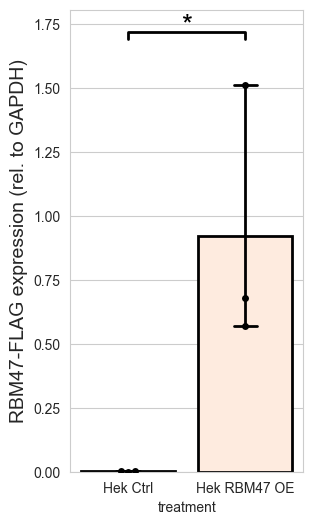

In [103]:
Westernblott_RBM47_OE_quantification = pd.DataFrame({'PSI_E24c' : [
0.000567614,
0.000886921,
0.001879443,
0.567954112,
0.680190195,
1.510938541
                                                    ],
                                           'treatment' : ['Hek Ctrl', 'Hek Ctrl', 'Hek Ctrl',
                                                'Hek RBM47 OE', 'Hek RBM47 OE', 'Hek RBM47 OE']
                                         })

palette_generation_3 = sns.color_palette("RdGy_r", 8)
DATA = Westernblott_RBM47_OE_quantification
y_limit = 1.8
x_data = 'treatment'
y_data = 'PSI_E24c'
group1 = DATA.query('treatment == "Hek Ctrl"')[y_data]
group2 = DATA.query('treatment == "Hek RBM47 OE"')[y_data]

plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation_3[0],
                        palette_generation_3[4]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#plot.set(yscale="log")

#statistics1
p_ttest_1 = statistic_f(group1, group2)
cohensd_1 = cohens_d(group1, group2)


#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest_1)
x1, x2 = [0, 1]   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)


#print(stat_text)
print('Pvalue1: ' + str(p_ttest_1))
print('Cohen´s d 1: ' + str(cohensd_1))

plot.set_ylabel("RBM47-FLAG expression (rel. to GAPDH)", fontsize=14)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/RBM47_OE_quantification_reltoGAPDH_westernblott.png", dpi=600, bbox_inches='tight')

# RBM47 knockdown

In [104]:
E24c_splicing_RBM47_KO = pd.DataFrame({'PSI_E24c' : 
                                       [0.153331631, 0.161688104, 0.101034164, 
                                       0.065283243, 0.03235441, 0.044363869]
                                      ,
                                      'treatment' : 
                                       ['siCtrl', 'siCtrl','siCtrl',
                                        'siRBM47', 'siRBM47', 'siRBM47',]
                                      })


The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 0.012714773432444008
Cohen´s d 1: 4.2931110745303895


Text(-4.902777777777777, 0.5, 'PSI exon 24c')

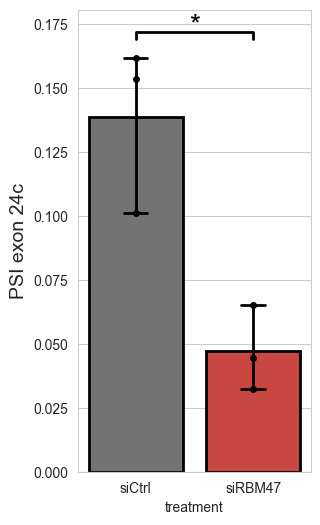

In [105]:
palette_generation_3 = sns.color_palette("RdGy_r", 5)
DATA = E24c_splicing_RBM47_KO
y_limit = 0.18
x_data = 'treatment'
y_data = 'PSI_E24c'
group1 = DATA.query('treatment == "siCtrl"')[y_data]
group2 = DATA.query('treatment == "siRBM47"')[y_data]


plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation_3[0],
                        palette_generation_3[4],
                        palette_generation_3[1],
                        palette_generation_3[3]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics1
p_ttest = statistic_f(group1, group2)
cohensd = cohens_d(group1, group2)

#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest)
x1, x2 = [0, 1]   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)


#print(stat_text)
print('Pvalue1: ' + str(p_ttest))
print('Cohen´s d 1: ' + str(cohensd))

plot.set_ylabel("PSI exon 24c", fontsize=14)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/E24c_splicing_RBM47_KO.png", dpi=600, bbox_inches='tight')

In [106]:
RBM47_GE_RBM47_KO = pd.DataFrame({'RBM47_GE' : 
                                       [0.968312644, 0.878762273, 1.171652576,
                                        0.263074777, 0.166494317, 0.355653641]
                                      ,
                                      'treatment' : 
                                       ['siCtrl', 'siCtrl','siCtrl',
                                        'siRBM47', 'siRBM47', 'siRBM47',]
                                      })


The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 0.00190277407590115
Cohen´s d 1: 7.26884192660727


Text(2.847222222222223, 0.5, 'RBM47 gene expresison (FoldChange)')

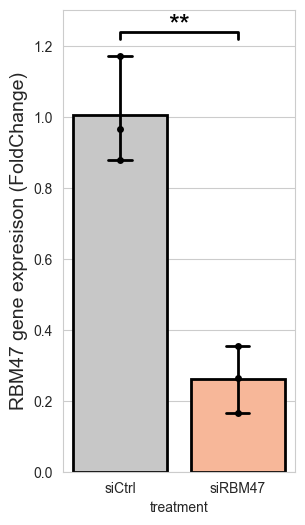

In [107]:
palette_generation_3 = sns.color_palette("RdGy_r", 5)
DATA = RBM47_GE_RBM47_KO
y_limit = 1.3
x_data = 'treatment'
y_data = 'RBM47_GE'
group1 = DATA.query('treatment == "siCtrl"')[y_data]
group2 = DATA.query('treatment == "siRBM47"')[y_data]


plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation_3[1],
                        palette_generation_3[3],
                        palette_generation_3[1],
                        palette_generation_3[3]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics1
p_ttest = statistic_f(group1, group2)
cohensd = cohens_d(group1, group2)

#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest)
x1, x2 = [0, 1]   
y, h, col = y_limit-(y_limit*0.06), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)


#print(stat_text)
print('Pvalue1: ' + str(p_ttest))
print('Cohen´s d 1: ' + str(cohensd))

plot.set_ylabel("RBM47 gene expresison (FoldChange)", fontsize=14)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/RBM47_GE_RBM47_KO.png", dpi=600, bbox_inches='tight')

# Minigene

In [108]:
Minigene_hek = pd.read_excel(PATH + '/Projects/SEC31A_Exon24c/SEC31AE24c_minigene_Hek_results.xlsx')

In [109]:
Minigene_hek['sample'] = Minigene_hek['FLAG'] + ' ' + Minigene_hek['Minigene']

The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 6.76758429787655e-05
Cohen´s d 1: -17.15879629690484
The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue3: 0.0022180130812480335
Cohen´s d 3: -6.978104679555447
The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue6: 0.0634865483944118
Cohen´s d 6: -2.54730659146936
The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue7: 0.33228113072614074
Cohen´s d 7: 1.10207402412303


Text(49.847222222222214, 0.5, 'PSI exon 24c')

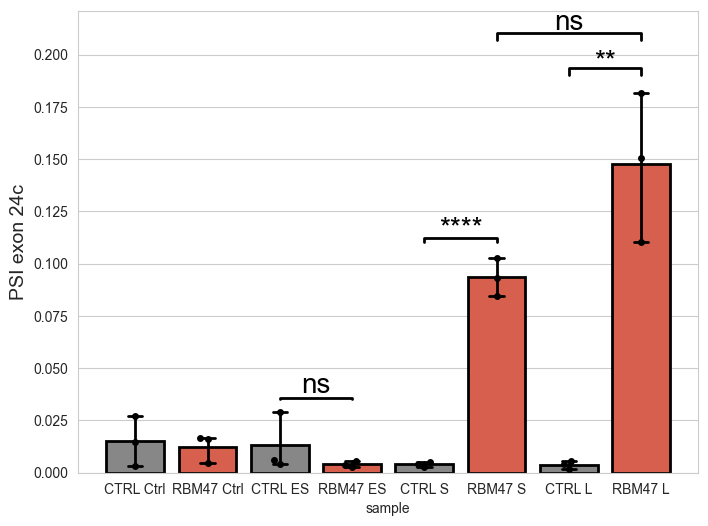

In [110]:
palette_generation = sns.color_palette("RdGy_r", 9)
DATA = Minigene_hek.query('sample != "CTRL SD"').query('sample != "RBM47 SD"')
x_data = 'sample'
y_data = 'E24 inclusion'
group1 = DATA.query('sample == "CTRL S"')[y_data]
group2 = DATA.query('sample == "RBM47 S"')[y_data]
group5 = DATA.query('sample == "CTRL L"')[y_data]
group6 = DATA.query('sample == "RBM47 L"')[y_data]
group7 = DATA.query('sample == "CTRL ES"')[y_data]
group8 = DATA.query('sample == "RBM47 ES"')[y_data]


plt.figure(figsize=(8,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation[1],
                        palette_generation[7]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics1
p_ttest1 = statistic_f(group1, group2)
cohensd1 = cohens_d(group1, group2)

#statistics depiction with asterisks
y_limit = max(group2)+0.02
asterisk_text_1 = statistic_asterisk(p_ttest1)
x1, x2 = [4, 5]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)

#print(stat_text)
print('Pvalue1: ' + str(p_ttest1))
print('Cohen´s d 1: ' + str(cohensd1))


p_ttest3 = statistic_f(group5, group6)
cohensd3 = cohens_d(group5, group6)

#statistics depiction with asterisks
y_limit = max(group6)+0.03
asterisk_text_2 = statistic_asterisk(p_ttest3)
x1, x2 = [6, 7]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_2, ha='center', va='bottom', color=col, size = 20)

print('Pvalue3: ' + str(p_ttest3))
print('Cohen´s d 3: ' + str(cohensd3))

p_ttest6 = statistic_f(group2, group6)
cohensd6 = cohens_d(group2, group6)

#statistics depiction with asterisks
y_limit=0.23
asterisk_text_2 = statistic_asterisk(p_ttest6)
x1, x2 = [5, 7]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y+.002, asterisk_text_2, ha='center', va='bottom', color=col, size = 20)

print('Pvalue6: ' + str(p_ttest6))
print('Cohen´s d 6: ' + str(cohensd6))

p_ttest7 = statistic_f(group7, group8)
cohensd7 = cohens_d(group7, group8)

#statistics depiction with asterisks
y_limit = max(group7)+0.01
asterisk_text_2 = statistic_asterisk(p_ttest6)
x1, x2 = [2, 3]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_2, ha='center', va='bottom', color=col, size = 20)

print('Pvalue7: ' + str(p_ttest7))
print('Cohen´s d 7: ' + str(cohensd7))

plot.set_ylabel("PSI exon 24c", fontsize=14)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/E24c_minigene_Hek.png", dpi=600, bbox_inches='tight')

# Caco2 differentiation and MO treatment

In [111]:
splicing_Caco2_MO_diff = pd.DataFrame({'PSI_E24c' : [0.151119692, 0.150565958, 0.13446239,
                                                     0.542274688, 0.605173626, 0.603249424,
                                                     0.066010369, 0.043055281, 0.073993873],
            
                                       'treatment' : ['MOCtrl', 'MOCtrl', 'MOCtrl',
                                                     'diff. MOCtrl', 'diff. MOCtrl', 'diff. MOCtrl',
                                                     'diff. MO24c', 'diff. MO24c', 'diff. MO24c']
                                                      })

The data is normaly distributed and has equal variance so Student´s T-test was perfomred
The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 3.336928647653745e-05
Cohen´s d 1: -20.511072321062915
Pvalue2: 2.087841688673422e-05
Cohen´s d 2: 23.08126546936543


Text(15.347222222222223, 0.5, 'PSI exon 24c')

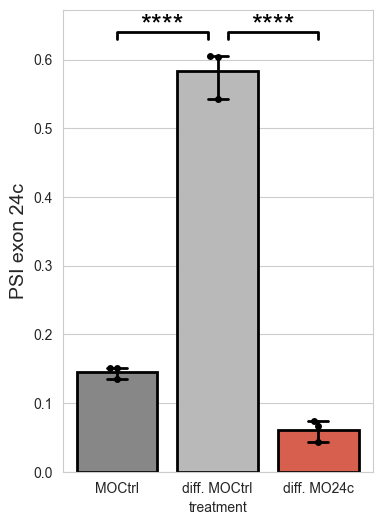

In [112]:
palette_generation = sns.color_palette("RdGy_r", 9)
DATA = splicing_Caco2_MO_diff
y_limit = .70
x_data = 'treatment'
y_data = 'PSI_E24c'
group1 = DATA.query('treatment == "MOCtrl"')[y_data]
group2 = DATA.query('treatment == "diff. MOCtrl"')[y_data]
group3 = DATA.query('treatment == "diff. MO24c"')[y_data]


plt.figure(figsize=(4,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation[1],
                        palette_generation[2],
                        palette_generation[7]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics1
p_ttest1 = statistic_f(group1, group2)
cohensd1 = cohens_d(group1, group2)

p_ttest2 = statistic_f(group2, group3)
cohensd2 = cohens_d(group2, group3)


#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest1)
x1, x2 = [0, 0.9]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)

#statistics depiction with asterisks
asterisk_text_2 = statistic_asterisk(p_ttest2)
x1, x2 = [1.1, 2]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_2, ha='center', va='bottom', color=col, size = 20)


#print(stat_text)
print('Pvalue1: ' + str(p_ttest1))
print('Cohen´s d 1: ' + str(cohensd1))

print('Pvalue2: ' + str(p_ttest2))
print('Cohen´s d 2: ' + str(cohensd2))


plot.set_ylabel("PSI exon 24c", fontsize=14)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/E24c_splicing_Caco2diff_MO.png", dpi=600, bbox_inches='tight')

The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 0.007413129863497763
Cohen´s d 1: -5.0146801007479285


Text(-20.40277777777778, 0.5, 'RBM47 gene expression (rel. to GAPDH)')

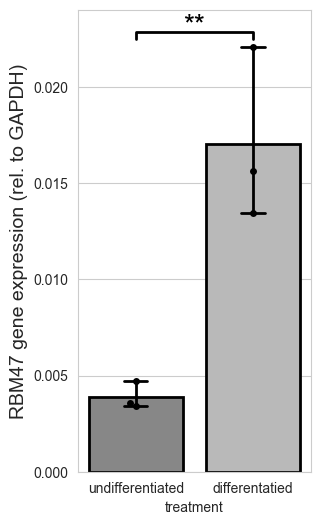

In [117]:
Exon24c_splicing_Caco2_MO_diff = pd.DataFrame({'Y_data' : [0.004693891,
                                                        0.003400588,
                                                        0.003594483,
                                                        0.013461659,
                                                        0.022097087,
                                                        0.015625
                                                     ],
                                       'treatment' : [
                                                      'undifferentiated', 'undifferentiated', 'undifferentiated',
                                                     
                                                     'differentatied', 'differentatied', 'differentatied'
                                                     ]
                                                      })


palette_generation = sns.color_palette("RdGy_r", 9)
DATA = Exon24c_splicing_Caco2_MO_diff
y_limit = 0.025
x_data = 'treatment'
y_data = 'Y_data'
group1 = DATA.query('treatment == "undifferentiated"')[y_data]
group2 = DATA.query('treatment == "differentatied"')[y_data]


plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation[1], palette_generation[2]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics1
p_ttest1 = statistic_f(group1, group2)
cohensd1 = cohens_d(group1, group2)


#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest1)
x1, x2 = [0, 1]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)

#print(stat_text)
print('Pvalue1: ' + str(p_ttest1))
print('Cohen´s d 1: ' + str(cohensd1))


plot.set_ylabel("RBM47 gene expression (rel. to GAPDH)", fontsize=14)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/RBM47_GE_Caco2diff.png", dpi=600, bbox_inches='tight')

# Caco-2 Lipid transport assay

The data is normaly distributed and has equal variance so Student´s T-test was perfomred
Pvalue1: 0.004631988892270807
Cohen´s d 1: 5.716782864565946


Text(-4.902777777777777, 0.5, 'Fluorescence signal ratio (Basal / Apical)')

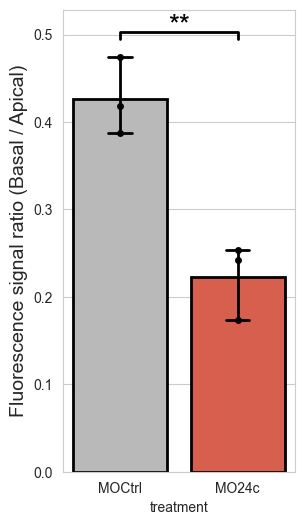

In [119]:
NBD_basal_ratio_Caco2_MO_diff = pd.DataFrame({'y_data' : [0.387943593,
                                                        0.418247793,
                                                        0.473844901,
                                                        0.242668238,
                                                        0.173260996,
                                                        0.253714371
                                                     ],
                                       'treatment' : [#'MOCtrl', 'MOCtrl', 'MOCtrl',
                                                      'MOCtrl', 'MOCtrl', 'MOCtrl',  
                                                     #'MO24c', 'MO24c', 'MO24c', 
                                                      'MO24c', 'MO24c',  'MO24c'
                                                     ]
                                                      })


palette_generation = sns.color_palette("RdGy_r", 9)
DATA = NBD_basal_ratio_Caco2_MO_diff
y_limit = 0.55
x_data = 'treatment'
y_data = 'y_data'
group1 = DATA.query('treatment == "MOCtrl"')[y_data]
group2 = DATA.query('treatment == "MO24c"')[y_data]


plt.figure(figsize=(3,6))
plot = sns.swarmplot(data = DATA, x = x_data, y = y_data,  alpha=1, color='black')
plot = sns.barplot(data= DATA, x = x_data, y = y_data
            , palette = [palette_generation[2],
                        palette_generation[7]]
            ,capsize = 0.2,             
            saturation = 8,             
            errcolor = 'black', errwidth = 2,
            linewidth=2, edgecolor="0")

#statistics1
p_ttest1 = statistic_f(group1, group2)
cohensd1 = cohens_d(group1, group2)


#statistics depiction with asterisks
asterisk_text_1 = statistic_asterisk(p_ttest1)
x1, x2 = [0, 1]   
y, h, col = y_limit-(y_limit*0.1), y_limit*0.015, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=2, c=col)
plt.text((x1+x2)*.5, y, asterisk_text_1, ha='center', va='bottom', color=col, size = 20)

#print(stat_text)
print('Pvalue1: ' + str(p_ttest1))
print('Cohen´s d 1: ' + str(cohensd1))


plot.set_ylabel("Fluorescence signal ratio (Basal / Apical)", fontsize=14)
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/Lipid_assay_rel_basal_signal.png", dpi=600, bbox_inches='tight')


# Alphafold

In [121]:
path = PATH + '/alphafold/multimer/active_fragment/SAR1A_SEC23_SEC31A_Iso1_activeFragment_multimer/'
file_path = glob.glob(path + '*ranking_confidence.npy') 
model_list = []
rankingconf_list = []
for file in file_path:
    file_name = file.replace(path[:-1] + '\\' , '')
    file_name = file_name.replace('_ranking_confidence.npy' , '')
    file_name = file_name.replace('_multimer_v3_pred' , '')
    Iso1_rankingconf = np.load(file)
    model_list.append(file_name)
    rankingconf_list.append(Iso1_rankingconf)
Iso1_ranks = pd.DataFrame({'Models' : model_list, 'ranking confidence' : rankingconf_list})
Iso1_ranks.sort_values(by = 'ranking confidence', ascending = False)

,Models,ranking confidence
20,result_model_5_0,0.8632264280848673
18,result_model_4_3,0.8610737304592926
24,result_model_5_4,0.8587309317878349
22,result_model_5_2,0.8575401729013201
21,result_model_5_1,0.8533113525696995
19,result_model_4_4,0.8518031886993938
16,result_model_4_1,0.8498058281151843
23,result_model_5_3,0.8482576648818
1,result_model_1_1,0.8466572411224259
17,result_model_4_2,0.845659031344673


In [122]:
path = PATH + '/alphafold/multimer/active_fragment/SAR1A_SEC23_SEC31A_Iso8_activeFragment_multimer/'
file_path = glob.glob(path + '*ranking_confidence.npy') 
model_list = []
rankingconf_list = []
for file in file_path:
    file_name = file.replace(path[:-1] + '\\' , '')
    file_name = file_name.replace('_ranking_confidence.npy' , '')
    file_name = file_name.replace('_multimer_v3_pred' , '')
    Iso8_rankingconf = np.load(file)
    model_list.append(file_name)
    rankingconf_list.append(Iso8_rankingconf)
Iso8_ranks = pd.DataFrame({'Models' : model_list, 'ranking confidence' : rankingconf_list})
Iso8_ranks.sort_values(by = 'ranking confidence', ascending = False)

,Models,ranking confidence
17,result_model_4_2,0.8560813818192203
18,result_model_4_3,0.8526413558301303
22,result_model_5_2,0.8502716812396358
24,result_model_5_4,0.8486471890954772
21,result_model_5_1,0.8475499768335129
20,result_model_5_0,0.8420872291735659
23,result_model_5_3,0.8415002019905939
16,result_model_4_1,0.8414371504830702
19,result_model_4_4,0.8392662612540601
15,result_model_4_0,0.8374016396274534


In [123]:
path = PATH + '/alphafold/multimer/active_fragment/SAR1A_SEC23_SEC31A_Iso1_activeFragment_multimer/'
file_path = glob.glob(path + '*plddt.npy') 
Iso1_plddt = {}
for file in file_path:
    file_name = file.replace(path[:-1] + '\\' , '')
    file_name = file_name.replace('_plddt.npy' , '')
    file_name = file_name.replace('result_model_' , '')
    file_name = file_name.replace('_multimer_v3_pred' , '')
    plddt_i = np.load(file)
    Iso1_plddt[file_name] = plddt_i

In [124]:
path = PATH + '/alphafold/multimer/active_fragment/SAR1A_SEC23_SEC31A_Iso8_activeFragment_multimer/'
file_path = glob.glob(path + '*plddt.npy') 
Iso8_plddt = {}
for file in file_path:
    file_name = file.replace(path[:-1] + '\\' , '')
    file_name = file_name.replace('_plddt.npy' , '')
    file_name = file_name.replace('result_model_' , '')
    file_name = file_name.replace('_multimer_v3_pred' , '')
    plddt_i = np.load(file)
    Iso8_plddt[file_name] = plddt_i

Text(0, 0.5, 'pLDDT')

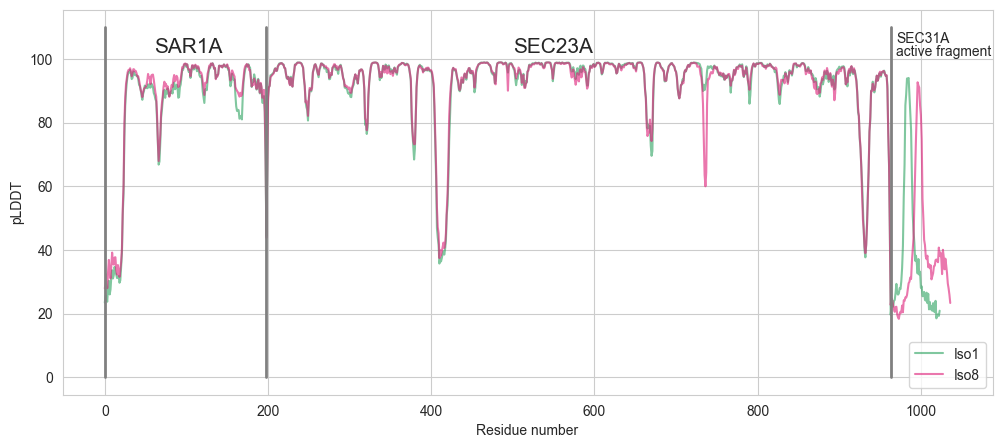

In [125]:
plt.figure(figsize=(12,5))
plt.plot(Iso1_plddt['5_0'], color = '#2ca25f', alpha = .6, label = 'Iso1')
plt.plot(Iso8_plddt['4_2'], color = '#dd1c77', alpha = .6, label = 'Iso8')
plt.legend(loc='lower right')


plt.plot([0, 0], [110, 0], linewidth=2, color = 'grey')
plt.plot([198, 198], [110, 0], linewidth=2, color = 'grey')
plt.plot([963, 963], [110, 0], linewidth=2, color = 'grey')
#plt.plot([1050, 1050], [110, 0], linewidth=2, color = 'grey')

plt.text(60, 102, 'SAR1A', fontsize=15)
plt.text(500, 102, 'SEC23A', fontsize=15)
plt.text(970, 105, 'SEC31A', fontsize=10)
plt.text(970, 101, 'active fragment', fontsize=10)

plt.xlabel("Residue number")
plt.ylabel("pLDDT")
#plt.show()
#
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/Alphafold_SAR1_SEC23_SEC31A_activeFragment_plddt_Iso1_8.png", dpi = 600, bbox_inches = "tight")


In [126]:
path = PATH + '/alphafold/multimer/active_fragment/SAR1A_SEC23_SEC31A_Iso1_activeFragment_multimer/'
file_path = glob.glob(path + '*pae.npy') 
Iso1_pae = {}
for file in file_path:
    file_name = file.replace(path[:-1] + '\\' , '')
    file_name = file_name.replace('_pae.npy' , '')
    file_name = file_name.replace('result_model_' , '')
    file_name = file_name.replace('_multimer_v3_pred' , '')
    pae_i = np.load(file)
    Iso1_pae[file_name] = pd.DataFrame(pae_i)
    

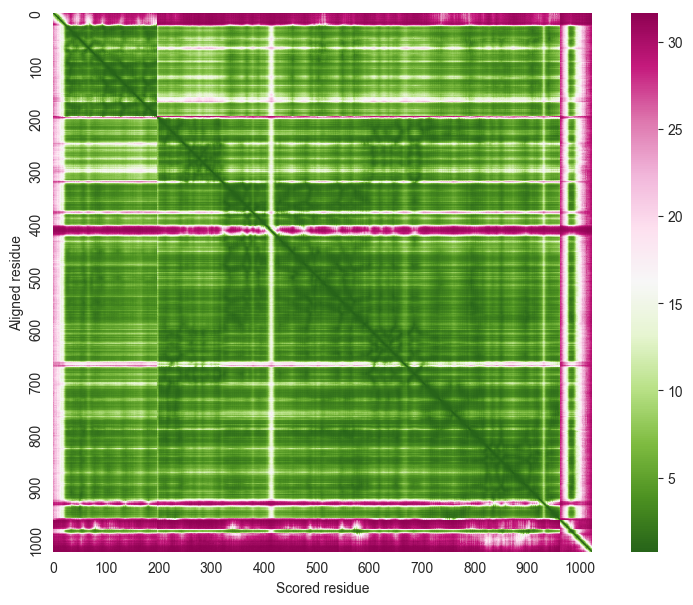

In [127]:
plt.figure(figsize=(10,7))
plot = sns.heatmap(Iso1_pae['5_0'], cmap = 'PiYG_r', xticklabels=100, yticklabels=100, square = True
              )
#plt.xticks(ticks=np.arange(0,len(Iso8_pae['5_2']),100))
#plt.yticks(ticks=np.arange(0,len(Iso8_pae['5_2']),100))
#yticks = np.linspace(10,100,10)
#ylabels = np.linspace(100,1000,10)

plot.set(xlabel='Scored residue', ylabel='Aligned residue')
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/Alphafold_SAR1_SEC23_SEC31A_activeFragment_pae_Iso1.png", dpi = 600, bbox_inches = "tight")

plt.show()


In [128]:
path = PATH + '/alphafold/multimer/active_fragment/SAR1A_SEC23_SEC31A_Iso8_activeFragment_multimer/'
file_path = glob.glob(path + '*pae.npy') 
Iso8_pae = {}
for file in file_path:
    file_name = file.replace(path[:-1] + '\\' , '')
    file_name = file_name.replace('_pae.npy' , '')
    file_name = file_name.replace('result_model_' , '')
    file_name = file_name.replace('_multimer_v3_pred' , '')
    pae_i = np.load(file)
    Iso8_pae[file_name] = pd.DataFrame(pae_i)

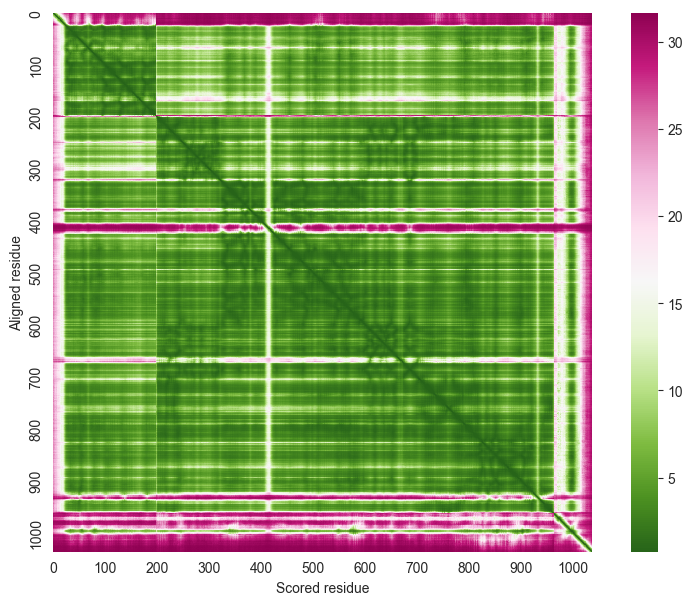

In [129]:
plt.figure(figsize=(10,7))
plot = sns.heatmap(Iso8_pae['5_2'], cmap = 'PiYG_r', xticklabels=100, yticklabels=100, square = True
              )
#plt.xticks(ticks=np.arange(0,len(Iso8_pae['5_2']),100))
#plt.yticks(ticks=np.arange(0,len(Iso8_pae['5_2']),100))
#yticks = np.linspace(10,100,10)
#ylabels = np.linspace(100,1000,10)

plot.set(xlabel='Scored residue', ylabel='Aligned residue')
#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/Alphafold_SAR1_SEC23_SEC31A_activeFragment_pae_Iso8.png", dpi = 600, bbox_inches = "tight")

plt.show()



In [133]:
PAE_Iso1_plot_df = pd.DataFrame({'pae' : Iso1_pae['5_1'][963:][800]})#.reset_index()
#PAE_Iso1_plot_df = PAE_Iso1_plot_df.drop('index', axis = 1)
PAE_Iso1_plot_df['index'] = range(976, 1037)
PAE_Iso1_plot_df = PAE_Iso1_plot_df.set_index('index')
PAE_Iso1_plot_df

,pae
index,
976,30.147200
977,29.985102
978,29.663769
979,29.248459
980,28.725372
...,...
1032,29.200399
1033,29.818600
1034,30.080000


Text(0, 0.5, 'Predicted Aligned Error')

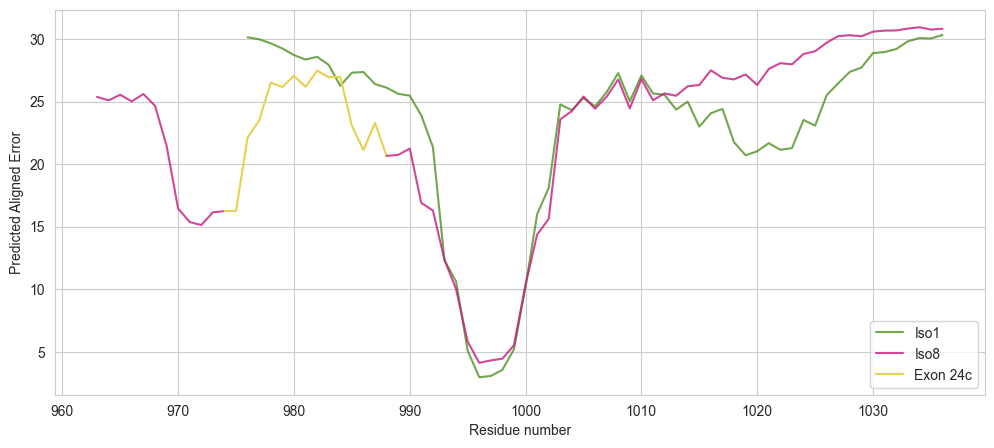

In [134]:
plt.figure(figsize=(12,5))
plt.plot(PAE_Iso1_plot_df, color = '#4d9221', alpha = .8, label = 'Iso1')
plt.plot(Iso8_pae['5_2'][963:975][800], color = '#c51b7d', alpha = .8, label = 'Iso8')
plt.plot(Iso8_pae['5_2'][974:989][800], color = sns.color_palette("cividis", 10)[9], alpha = 1, label = 'Exon 24c')
plt.plot(Iso8_pae['5_2'][988:][800], color = '#c51b7d', alpha = .8)
plt.legend(loc='lower right')


plt.xlabel("Residue number")
plt.ylabel("Predicted Aligned Error")

#plt.savefig("C:/Users/felix/Documents/Phd/Projects/SEC31A_Exon24c/Figures/Alphafold_pae_Iso1_8.png", dpi = 600, bbox_inches = "tight")


# Polypeptide alignment

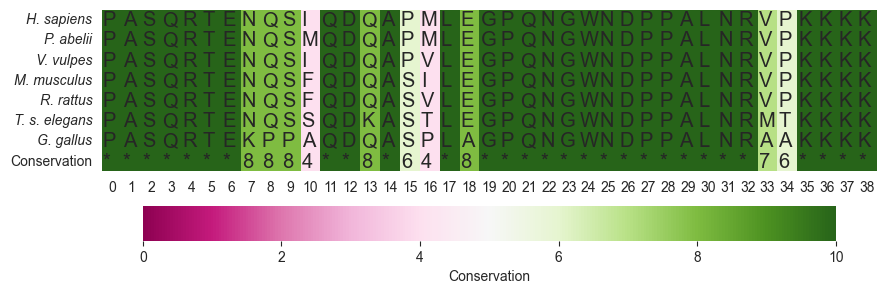

In [135]:

peptide_align = pd.DataFrame({'H. sapiens' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]
                             ,'P. abelii' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]
                             ,'V. vulpes' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]
                             ,'M. musculus' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]
                             ,'R. rattus' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]
                             ,'T. s. elegans' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]
                             ,'G. gallus' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]
                             ,'Conservation' : [10,10,10,10,10,10,10,8,8,8,4,10,10,8,10,6,4,10,8,10,10,10,10,10,10,10,10,10,10,10,10,10,10,7,6,10,10,10,10]})

plt.figure(figsize=(10,3))
plot = sns.heatmap(peptide_align.transpose(), cmap = 'PiYG', square = False,  vmin=0, vmax=10,linewidth=.0
                   , cbar_kws={'label': 'Conservation', 'location' : "bottom"}
                   )
for label in plot.get_yticklabels():
    if label.get_text() != 'Conservation':
        label.set_fontstyle("italic")
    
sequences = [['P', 'A', 'S', 'Q', 'R', 'T', 'E', 'N', 'Q', 'S', 'I', 'Q', 'D', 'Q', 'A', 'P', 'M', 'L', 'E', 'G', 'P', 'Q', 'N', 'G', 'W', 'N', 'D', 'P', 'P', 'A', 'L', 'N', 'R', 'V', 'P', 'K', 'K', 'K', 'K'],
['P', 'A', 'S', 'Q', 'R', 'T', 'E', 'N', 'Q', 'S', 'M', 'Q', 'D', 'Q', 'A', 'P', 'M', 'L', 'E', 'G', 'P', 'Q', 'N', 'G', 'W', 'N', 'D', 'P', 'P', 'A', 'L', 'N', 'R', 'V', 'P', 'K', 'K', 'K', 'K'],
['P', 'A', 'S', 'Q', 'R', 'T', 'E', 'N', 'Q', 'S', 'I', 'Q', 'D', 'Q', 'A', 'P', 'V', 'L', 'E', 'G', 'P', 'Q', 'N', 'G', 'W', 'N', 'D', 'P', 'P', 'A', 'L', 'N', 'R', 'V', 'P', 'K', 'K', 'K', 'K'],
['P', 'A', 'S', 'Q', 'R', 'T', 'E', 'N', 'Q', 'S', 'F', 'Q', 'D', 'Q', 'A', 'S', 'I', 'L', 'E', 'G', 'P', 'Q', 'N', 'G', 'W', 'N', 'D', 'P', 'P', 'A', 'L', 'N', 'R', 'V', 'P', 'K', 'K', 'K', 'K'],
['P', 'A', 'S', 'Q', 'R', 'T', 'E', 'N', 'Q', 'S', 'F', 'Q', 'D', 'Q', 'A', 'S', 'V', 'L', 'E', 'G', 'P', 'Q', 'N', 'G', 'W', 'N', 'D', 'P', 'P', 'A', 'L', 'N', 'R', 'V', 'P', 'K', 'K', 'K', 'K'],
['P', 'A', 'S', 'Q', 'R', 'T', 'E', 'N', 'Q', 'S', 'S', 'Q', 'D', 'K', 'A', 'S', 'T', 'L', 'E', 'G', 'P', 'Q', 'N', 'G', 'W', 'N', 'D', 'P', 'P', 'A', 'L', 'N', 'R', 'M', 'T', 'K', 'K', 'K', 'K'],
['P', 'A', 'S', 'Q', 'R', 'T', 'E', 'K', 'P', 'P', 'A', 'Q', 'D', 'Q', 'A', 'S', 'P', 'L', 'A', 'G', 'P', 'Q', 'N', 'G', 'W', 'N', 'D', 'P', 'P', 'A', 'L', 'N', 'R', 'A', 'A', 'K', 'K', 'K', 'K']
            , ['*','*','*','*','*','*','*','8','8','8','4','*','*','8','*','6','4','*','8','*','*','*','*','*','*','*','*','*','*','*','*','*','*','7','6','*','*','*','*']]
y = -1
for species in sequences:
    x = 0
    y = y + 1
    for aminoacid in species:
        
        plot.text(x + .05, y + .8, aminoacid , size = 14.5)
        x = x + 1

#plt.savefig("G:/Projects/SEC31A_Exon24c/Figures/Exon24c_conservation_long.png", dpi = 600, bbox_inches = "tight")

plt.show()